# Description

Analyze trading execution quality.

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.finance.target_position_df_processing as cftpdp
import core.plotting as coplotti
import core.plotting.execution_stats as cplexsta
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.ccxt.utils as imv2ccuti
import im_v2.common.universe as ivcu
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logger as obcccclo
import oms.child_order_quantity_computer.child_order_quantity_computer_instances as ocoqccoqci
import oms.order.order_converter as oororcon

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-2f1111f1-21c6-4e82-8784-696a23d2d1fa.json'
INFO  # Git
  branch_name='CmTask8466_investigate_recent_runs_2'
  hash='8aa66a87b'
  # Last commits:
    * 8aa66a87b PomazkinG checkpoint                                                        (80 seconds ago) Thu May 30 16:32:51 2024  (HEAD -> CmTask8466_investigate_recent_runs_2)
    * 2250c41a4 Juraj Smeriga CmampTask8319_Speed_up_RawDataReaderload_db_table_head (#8330)    (42 minutes ago) Thu May 30 15:52:20 2024  (origin/master, origin/HEAD, origin/CmTask8440_make_dag_tags_string_instead_of_list, master)
    * 0046f0eb5 Grigorii Pomazkin Cm task8328 investigate slippage (#8464)                          (   4 hours ago) Thu May 30 13:01:04 2024           
# Machine info
  system=Linux
  node name=a8c8a3caa8f7
  release=5.15.0-1058-aws
  version=#64~20.04.1-Ubuntu SMP Tue Apr 9 11:12:27 UTC 2024
  machine=x86_64
  processor=x86

# Config

In [3]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
# Set 'replace_ecs_tokyo = True' if running the notebook manually.
replace_ecs_tokyo = False
config = cconfig.get_notebook_config(
    config_file_path=config_file_name, replace_ecs_tokyo=replace_ecs_tokyo
)
if config is None:
    system_log_dir = "/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts"
    id_col = "asset_id"
    price_col = "close"
    universe_version = "v8.1"
    vendor = "CCXT"
    mode = "trade"
    test_asset_id = 1020313424
    bar_duration = "120T"
    child_order_execution_freq = "10S"
    use_historical = True
    system_config_dir = system_log_dir.rstrip("/process_forecasts")
    # Load pickled SystemConfig.
    config_path = os.path.join(
        system_config_dir, "system_config.output.values_as_strings.pkl"
    )
    system_config = cconfig.load_config_from_pickle(config_path)
    # Get table name from SystemConfig.
    table_name = system_config[
        "market_data_config", "im_client_config", "table_name"
    ]
    #
    config_dict = {
        "meta": {
            "id_col": id_col,
            "price_col": price_col,
            "use_historical": use_historical,
        },
        "system_log_dir": system_log_dir,
        "market_data": {
            "vendor": vendor,
            "mode": mode,
            "universe": {
                "universe_version": universe_version,
                "test_asset_id": test_asset_id,
            },
            "im_client_config": {"table_name": table_name},
        },
        "execution_parameters": {
            "bar_duration": bar_duration,
            "execution_freq": child_order_execution_freq,
        },
    }
    config = cconfig.Config.from_dict(config_dict)
print(config)

WARNING No config found, returning None
meta: 
  id_col: asset_id
  price_col: close
  use_historical: True
system_log_dir: /shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts
market_data: 
  vendor: CCXT
  mode: trade
  universe: 
    universe_version: v8.1
    test_asset_id: 1020313424
  im_client_config: 
    table_name: ccxt_ohlcv_futures
execution_parameters: 
  bar_duration: 120T
  execution_freq: 10S


In [4]:
# Init the log reader.
log_dir = config.get_and_mark_as_used(("system_log_dir",))
ccxt_log_reader = obcccclo.CcxtLogger(log_dir)

WARNING Path '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts/args.json' doesn't exist!
WARNING Path '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts/balances' doesn't exist!
WARNING Path '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts/reduce_only/ccxt_child_order_responses' doesn't exist!
WARNING Path '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts/reduce_only/oms_child_orders' doesn't exist!


In [5]:
# Print the Broker config.
try:
    broker_config = ccxt_log_reader.load_broker_config(abort_on_missing_data=True)
    print(hprint.to_pretty_str(broker_config))
    scheduler_type = broker_config["child_order_quantity_computer"]["object_type"]
except FileNotFoundError:
    _LOG.warning(
        "broker_config file not present in %s, assuming Dynamic Scheduling",
        log_dir,
    )
    scheduler_type = "DynamicSchedulingChildOrderQuantityComputer"

{'bid_ask_lookback': '60S',
 'child_order_quantity_computer': {'object_type': 'DynamicSchedulingChildOrderQuantityComputer'},
 'limit_price_computer': {'_volatility_multiple': [1.5,
                                                   0.7,
                                                   0.7,
                                                   0.7,
                                                   0.7,
                                                   0.7,
                                                   0.7,
                                                   0.7,
                                                   0.7,
                                                   0.6,
                                                   0.6,
                                                   0.5,
                                                   0.25,
                                                   0.25,
                                                   0.25,
                               

In [6]:
# Print the used Config, if any.
experiment_config = obcccclo.load_config_for_execution_analysis(log_dir)
if experiment_config:
    print(experiment_config)

INFO  Loading config from /shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/system_config.output.values_as_strings.pkl
dag_config: 
  generate_feature_panels: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
    out_col_group: ()
    transformer_kwargs: 
      bar_normalization_method: volume
  resample: 
    in_col_groups: [('open',), ('high',), ('low',), ('close',), ('volume',), ('p1',), ('p2',), ('p3',), ('p_lr',), ('p_est',), ('p_diff',), ('q1',), ('q2',), ('q3',), ('q4',), ('q5',), ('q6',), ('q_mv',), ('q_mv_adj',), ('q_mv_os',), ('r1',), ('r2',), ('r3',), ('r4',), ('r5',), ('r6',), ('r_lr',), ('r_est',), ('v_ld',)]
    out_col_group: ()
    transformer_kwargs: 
      rule: 120T
      volume_weight: volume
    reindex_like_input: False
    join_output_with_input: False
  compute_vol: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',)]
    out_col_group: ()
    transformer

In [7]:
# Get the test asset ID from the config.
test_asset_id = config.get_and_mark_as_used(
    ("market_data", "universe", "test_asset_id")
)
id_col = config.get_and_mark_as_used(("meta", "id_col"))
price_col = config.get_and_mark_as_used(("meta", "price_col"))

In [8]:
bar_duration = config.get_and_mark_as_used(
    ("execution_parameters", "bar_duration")
)
exec_freq = config.get_and_mark_as_used(
    ("execution_parameters", "execution_freq")
)
# Initialize scheduler according to it's type.
scheduler = ocoqccoqci.get_child_order_quantity_computer_instance1(scheduler_type)
# Get the range of expected number of child orders.
range_filter = scheduler.get_range_filter(bar_duration, exec_freq)

# Load and aggregate data

## Load CCXT data

In [9]:
data = ccxt_log_reader.load_all_data(
    convert_to_dataframe=True, abort_on_missing_data=False
)

WARNING Missing required data for 'args': continuing as per user request


Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

Loading '/shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/syst…

WARNING Missing required data for 'balances': continuing as per user request
WARNING Missing required data for 'reduce_only_order_responses': continuing as per user request


### Order responses

In [10]:
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '10536850655', 'symbol': 'OPUSDT',...",10536850655,x-xcKtGhcu8758bc0ac4ad83216c1927,1715911210580,2024-05-17T02:00:10.580Z,NaN,1715911210580,OP/USDT:USDT,limit,GTC,False,False,buy,2.3570,None,42.4,0.0,NaN,0.0,42.4,open,None,[],[],None,None,None,1715911210580,2024-05-17 02:00:10.580000+00:00
1,"{'orderId': '10537584644', 'symbol': 'OPUSDT',...",10537584644,x-xcKtGhcu8484f28cc762ca87fec56a,1715918411103,2024-05-17T04:00:11.103Z,NaN,1715918411103,OP/USDT:USDT,limit,GTC,False,False,sell,2.3542,None,42.4,0.0,NaN,0.0,42.4,open,None,[],[],None,None,None,1715918411103,2024-05-17 04:00:11.103000+00:00
2,"{'orderId': '10537585230', 'symbol': 'OPUSDT',...",10537585230,x-xcKtGhcu413ff7f03618129338b206,1715918420733,2024-05-17T04:00:20.733Z,NaN,1715918420733,OP/USDT:USDT,limit,GTC,False,False,sell,2.3536,None,42.4,0.0,NaN,0.0,42.4,open,None,[],[],None,None,None,1715918420733,2024-05-17 04:00:20.733000+00:00


In [11]:
ccxt_order_response_df.loc[1]["info"]

{'orderId': '10537584644',
 'symbol': 'OPUSDT',
 'status': 'NEW',
 'clientOrderId': 'x-xcKtGhcu8484f28cc762ca87fec56a',
 'price': '2.3542000',
 'avgPrice': '0.00',
 'origQty': '42.4',
 'executedQty': '0.0',
 'cumQty': '0.0',
 'cumQuote': '0.00000000',
 'timeInForce': 'GTC',
 'type': 'LIMIT',
 'reduceOnly': False,
 'closePosition': False,
 'side': 'SELL',
 'positionSide': 'BOTH',
 'stopPrice': '0.0000000',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'LIMIT',
 'priceMatch': 'NONE',
 'selfTradePreventionMode': 'NONE',
 'goodTillDate': '0',
 'updateTime': '1715918411103'}

In [12]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    152 non-null    object             
 1   order                   152 non-null    int64              
 2   client_order_id         152 non-null    object             
 3   timestamp               152 non-null    int64              
 4   datetime                152 non-null    object             
 5   last_trade_timestamp    5 non-null      float64            
 6   lastUpdateTimestamp     152 non-null    int64              
 7   symbol                  152 non-null    object             
 8   order_type              152 non-null    object             
 9   time_in_force           152 non-null    object             
 10  post_only               152 non-null    bool               
 11  reduce_only             152 non-null    bool 

### OMS child orders

In [13]:
child_order_df = data["oms_child_orders"]
child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85,2024-05-17 02:00:10.404416+00:00,1020313424,limit,2024-05-17 02:00:10.404416+00:00,2024-05-17 02:00:20+00:00,0.0,42.4,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,236,2024-05-17 02:00:09.706000+00:00,2024-05-17 02:00:09.877516+00:00,2024-05-17 02:00:09.839907+00:00,57.4,660.9,597,10.0,0.000548,2.324816,2.3573,0.000542,2.298596,2.3574,0.000545,2.35735,2.311742,0.0001,0.424205,5.449586,2.3570,10536850655,85,1
140,2024-05-17 04:00:10.958357+00:00,1020313424,limit,2024-05-17 04:00:10.958357+00:00,2024-05-17 04:00:20+00:00,42.4,-42.4,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,303,2024-05-17 04:00:10.405000+00:00,2024-05-17 04:00:10.524502+00:00,2024-05-17 04:00:10.479442+00:00,18.6,1266.9,598,10.0,0.000597,2.538197,2.3533,0.000595,2.526145,2.3534,0.000596,2.35335,2.532178,0.0001,0.424926,5.959101,2.3542,10537584644,140,1
153,2024-05-17 04:00:20.602976+00:00,1020313424,limit,2024-05-17 04:00:20.602976+00:00,2024-05-17 04:00:30+00:00,42.4,-42.4,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,299,2024-05-17 04:00:19.873000+00:00,2024-05-17 04:00:19.918598+00:00,2024-05-17 04:00:19.889420+00:00,1297.8,227.7,597,10.0,0.000602,2.558261,2.3532,0.000599,2.546282,2.3533,0.000601,2.35325,2.552278,0.0001,0.424944,6.006149,2.3536,10537585230,153,1


In [14]:
child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 85 to 126
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   creation_timestamp         152 non-null    datetime64[ns, UTC]
 1   asset_id                   152 non-null    int64              
 2   type_                      152 non-null    object             
 3   start_timestamp            152 non-null    datetime64[ns, UTC]
 4   end_timestamp              152 non-null    datetime64[ns, UTC]
 5   curr_num_shares            152 non-null    float64            
 6   diff_num_shares            152 non-null    float64            
 7   tz                         152 non-null    object             
 8   extra_params               152 non-null    object             
 9   volatility_multiple        152 non-null    float64            
 10  wave_id                    152 non-null    int64              
 11  num_data_p

### CCXT fills (trades)

In [15]:
fills_df = data["ccxt_trades"]
# Annotate fills with child order wave ID.
fills_df = obccexqu.annotate_fills_df_with_wave_id(fills_df, child_order_df)
fills_df.head(3)

,timestamp,datetime,symbol,asset_id,id,order,side,takerOrMaker,price,amount,cost,transaction_cost,fees_currency,realized_pnl,first_timestamp,last_timestamp,first_datetime,last_datetime,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,wave_id
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-05-16 22:00:11.298000+00:00,2024-05-16 22:00:11.298000+00:00,2024-05-16 22:00:11.298000+00:00,AVAX/USDT:USDT,8717633868,795313092,21134583642,sell,taker,34.36200,1.0,34.36200,0.004673,USDT,0.0,2024-05-16 22:00:11.298000+00:00,2024-05-16 22:00:11.298000+00:00,2024-05-16 22:00:11.298000+00:00,2024-05-16 22:00:11.298000+00:00,0,1,1,0,0.0,1.0,1.0,0.0,0.0,34.36200,34.3620,0.00000,1
2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,GRT/USDT:USDT,1813442534,418898318,10333108262,sell,maker,0.30082,333.0,100.17306,-0.005009,USDT,0.0,2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,0,1,0,1,0.0,333.0,0.0,333.0,0.0,100.17306,0.0000,100.17306,1
2024-05-16 22:00:11.360000+00:00,2024-05-16 22:00:11.360000+00:00,2024-05-16 22:00:11.360000+00:00,INJ/USDT:USDT,2506553600,367462279,5633339145,sell,taker,23.46900,2.8,65.71320,0.008937,USDT,0.0,2024-05-16 22:00:11.360000+00:00,2024-05-16 22:00:11.360000+00:00,2024-05-16 22:00:11.360000+00:00,2024-05-16 22:00:11.360000+00:00,0,1,1,0,0.0,2.8,2.8,0.0,0.0,65.71320,65.7132,0.00000,1


In [16]:
fills_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2024-05-16 22:00:11.298000+00:00 to 2024-05-17 06:01:06.626000+00:00
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         98 non-null     datetime64[ns, UTC]
 1   datetime          98 non-null     datetime64[ns, UTC]
 2   symbol            98 non-null     object             
 3   asset_id          98 non-null     int64              
 4   id                98 non-null     int64              
 5   order             98 non-null     int64              
 6   side              98 non-null     object             
 7   takerOrMaker      98 non-null     object             
 8   price             98 non-null     float64            
 9   amount            98 non-null     float64            
 10  cost              98 non-null     float64            
 11  transaction_cost  98 non-null     float64            
 12  fe

### OMS parent orders

In [17]:
parent_order_df = data["oms_parent_orders"]
parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2024-05-16 22:00:07.507537+00:00,8717633868,price@twap,2024-05-16 22:00:07.507537+00:00,2024-05-17 00:00:00+00:00,0.0,-1.00,America/New_York,"{'ccxt_symbol': 'AVAX/USDT:USDT', 'stats': {'_..."
1,2024-05-16 22:00:07.507537+00:00,8968126878,price@twap,2024-05-16 22:00:07.507537+00:00,2024-05-17 00:00:00+00:00,0.0,-0.18,America/New_York,"{'ccxt_symbol': 'BNB/USDT:USDT', 'stats': {'_s..."
2,2024-05-16 22:00:07.507537+00:00,1670436375,price@twap,2024-05-16 22:00:07.507537+00:00,2024-05-17 00:00:00+00:00,0.0,-7.10,America/New_York,"{'ccxt_symbol': 'ENS/USDT:USDT', 'stats': {'_s..."


In [18]:
parent_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 185
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   creation_timestamp  60 non-null     datetime64[ns, UTC]
 1   asset_id            60 non-null     int64              
 2   type_               60 non-null     object             
 3   start_timestamp     60 non-null     datetime64[ns, UTC]
 4   end_timestamp       60 non-null     datetime64[ns, UTC]
 5   curr_num_shares     60 non-null     float64            
 6   diff_num_shares     60 non-null     float64            
 7   tz                  60 non-null     object             
 8   extra_params        60 non-null     object             
dtypes: datetime64[ns, UTC](3), float64(2), int64(1), object(3)
memory usage: 4.7+ KB


### CCXT fills

In [19]:
ccxt_fills = data["ccxt_fills"]
ccxt_fills.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '21134583642', 'symbol': 'AVAXUSDT...",21134583642,x-xcKtGhcu82b12edf49ff42b1cf6eef,1715896811298,2024-05-16T22:00:11.298Z,1.715897e+12,1715896811298,AVAX/USDT:USDT,limit,GTC,False,False,sell,34.358,None,1.00,34.362,34.362,1.0,0.00,closed,None,[],[],None,None,None,1715896811298,2024-05-16 22:00:11.298000+00:00
1,"{'orderId': '55932214350', 'symbol': 'BNBUSDT'...",55932214350,x-xcKtGhcua977277924cd81de683f76,1715896811358,2024-05-16T22:00:11.358Z,NaN,1715896819808,BNB/USDT:USDT,limit,GTC,False,False,sell,569.320,None,0.18,0.000,NaN,0.0,0.18,canceled,None,[],[],None,None,None,1715896819808,2024-05-16 22:00:19.808000+00:00
2,"{'orderId': '5280816571', 'symbol': 'ENSUSDT',...",5280816571,x-xcKtGhcuea5ce16d9d91b56f8404f5,1715896811356,2024-05-16T22:00:11.356Z,NaN,1715896819810,ENS/USDT:USDT,limit,GTC,False,False,sell,14.073,None,7.10,0.000,NaN,0.0,7.10,canceled,None,[],[],None,None,None,1715896819810,2024-05-16 22:00:19.810000+00:00


In [20]:
ccxt_fills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    152 non-null    object             
 1   order                   152 non-null    int64              
 2   client_order_id         152 non-null    object             
 3   timestamp               152 non-null    int64              
 4   datetime                152 non-null    object             
 5   last_trade_timestamp    60 non-null     float64            
 6   lastUpdateTimestamp     152 non-null    int64              
 7   symbol                  152 non-null    object             
 8   order_type              152 non-null    object             
 9   time_in_force           152 non-null    object             
 10  post_only               152 non-null    bool               
 11  reduce_only             152 non-null    bool 

In [21]:
# Check if `test_asset_id` is present
# If the `test_asset_id` is not present, choose the first traded asset.
traded_asset_ids = sorted(set(child_order_df["asset_id"]))
if test_asset_id not in traded_asset_ids:
    _LOG.info(
        "test_asset_id=%s not in traded asset id's. Updating...", test_asset_id
    )
    test_asset_id = traded_asset_ids[0]
_LOG.info("test_asset_id=%s", test_asset_id)

INFO  test_asset_id=1020313424


## Aggregate CCXT Data

In [22]:
bar_duration = config.get_and_mark_as_used(
    ("execution_parameters", "bar_duration")
)
# TODO(Paul): Look into adding tqdm.
# Aggregate order responses by bar.
bar_ccxt_order_aggregation = obccagfu.aggregate_ccxt_orders_by_bar(
    ccxt_order_response_df, bar_duration
)
# Aggregate fills by order.
ccxt_order_fills = obccagfu.aggregate_fills_by_order(fills_df)
# Aggregate fills by bar.
bar_fills = obccagfu.aggregate_fills_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)
# Aggregate buy/sell trade prices by bar.
trade_prices = obccagfu.compute_buy_sell_prices_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)
# Aggregate OMS child orders.
bar_child_order_aggregation = obccagfu.aggregate_child_limit_orders_by_bar(
    child_order_df, bar_duration
)

In [23]:
hpandas.df_to_str(bar_ccxt_order_aggregation, num_rows=6, log_level=logging.INFO)

order_count                                                                                                                                                                                                                             buy_order_count                                                                                                                                                                                                                             buy_limit_twap                                                                                                                                                                                                                               buy_limit_vwap                                                                                                                                                                                                                               buy_amount                                                                                                                                                                                                                             buy_notional                                                                                                                                                                                                                              sell_order_count                                                                                                                                                                                                                             sell_limit_twap                                                                                                                                                                                                                             sell_limit_vwap                                                                                                                                                                                                                              sell_amount                                                                                                                                                                                                                             sell_notional                                                                                                                                                                                                                            
asset_id                   1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878      1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878     1020313424 1106736216 1670436375 1775391824 1813442534   1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878     1020313424 1106736216 1670436375 1775391824 1813442534   1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878 1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878   1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155  2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 871763

In [24]:
hpandas.df_to_str(ccxt_order_fills, num_rows=6, log_level=logging.INFO)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
1906313125,2024-05-17 04:00:20.839000+00:00,2024-05-17 04:00:20.839000+00:00,2024-05-17 04:00:20.839000+00:00,2024-05-17 04:00:20.839000+00:00,PENDLE/USDT:USDT,2989693852,0,2,2,0,0.0,23.0,23.0,0.0,0.0,99.0966,99.0966,0.0,4.308548,23.0,99.0966,0.013477,0.0
1906825434,2024-05-17 06:00:12.229000+00:00,2024-05-17 06:00:12.229000+00:00,2024-05-17 06:00:12.229000+00:00,2024-05-17 06:00:12.229000+00:00,PENDLE/USDT:USDT,2989693852,1,0,0,1,23.0,0.0,0.0,23.0,99.2174,0.0,0.0,99.2174,4.3138,23.0,99.2174,-0.004961,-0.1208
2243291996,2024-05-17 02:00:50.643000+00:00,2024-05-17 02:00:50.643000+00:00,2024-05-17 02:00:50.643000+00:00,2024-05-17 02:00:50.643000+00:00,MINA/USDT:USDT,1775391824,0,3,3,0,0.0,126.0,126.0,0.0,0.0,99.7542,99.7542,0.0,0.7917,126.0,99.7542,0.013567,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55932218900,2024-05-16 22:00:35.541000+00:00,2024-05-16 22:00:35.541000+00:00,2024-05-16 22:00:35.541000+00:00,2024-05-16 22:00:35.541000+00:00,BNB/USDT:USDT,8968126878,0,1,0,1,0.0,0.18,0.0,0.18,0.0,102.4686,0.0,102.4686,569.27,0.18,102.4686,-0.005123,0.0
55933213181,2024-05-17 00:00:13.555000+00:00,2024-05-17 00:00:13.555000+00:00,2024-05-17 00:00:13.555000+00:00,2024-05-17 00:00:13.555000+00:00,BNB/USDT:USDT,8968126878,1,0,0,1,0.36,0.0,0.0,0.36,204.6168,0.0,0.0,204.6168,568.38,0.36,204.6168,-0.010231,0.1602
55934329092,2024-05-17 02:00:51.511000+00:00,2024-05-17 02:00:51.511000+00:00,2024-05-17 02:00:51.511000+00:00,2024-05-17 02:00:51.511000+00:00,BNB/USDT:USDT,8968126878,0,4,0,4,0.0,0.18,0.0,0.18,0.0,102.5478,0.0,102.5478,569.71,0.18,102.5478,-0.005127,0.2394


In [25]:
hpandas.df_to_str(bar_fills, num_rows=6, log_level=logging.INFO)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
"(2024-05-17 00:00:00+00:00, 1670436375)",2024-05-16 22:00:39.125000+00:00,2024-05-16 22:00:42.982000+00:00,2024-05-16 22:00:39.125000+00:00,2024-05-16 22:00:42.982000+00:00,ENS/USDT:USDT,1670436375,0,2,0,2,0.0,7.1,0.0,7.1,0.0,99.9112,0.0,99.9112,14.072,7.1,99.9112,-0.004996,0.0
"(2024-05-17 00:00:00+00:00, 1813442534)",2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,2024-05-16 22:00:18.111000+00:00,GRT/USDT:USDT,1813442534,0,1,0,1,0.0,333.0,0.0,333.0,0.0,100.17306,0.0,100.17306,0.30082,333.0,100.17306,-0.005009,0.0
"(2024-05-17 00:00:00+00:00, 2200033667)",2024-05-16 22:00:25.341000+00:00,2024-05-16 22:00:25.341000+00:00,2024-05-16 22:00:25.341000+00:00,2024-05-16 22:00:25.341000+00:00,TRB/USDT:USDT,2200033667,0,1,0,1,0.0,0.9,0.0,0.9,0.0,97.5834,0.0,97.5834,108.426,0.9,97.5834,-0.004879,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2024-05-17 08:00:00+00:00, 4417972573)",2024-05-17 06:01:06.623000+00:00,2024-05-17 06:01:06.626000+00:00,2024-05-17 06:01:06.623000+00:00,2024-05-17 06:01:06.626000+00:00,LDO/USDT:USDT,4417972573,2,0,0,2,59.0,0.0,0.0,59.0,98.5418,0.0,0.0,98.5418,1.6702,59.0,98.5418,-0.004927,0.6254
"(2024-05-17 08:00:00+00:00, 6335759645)",2024-05-17 06:00:44.207000+00:00,2024-05-17 06:00:44.207000+00:00,2024-05-17 06:00:44.207000+00:00,2024-05-17 06:00:44.207000+00:00,ICP/USDT:USDT,6335759645,1,0,0,1,4.0,0.0,0.0,4.0,48.756,0.0,0.0,48.756,12.189,4.0,48.756,-0.002438,0.384
"(2024-05-17 08:00:00+00:00, 8717633868)",2024-05-17 06:00:24.072000+00:00,2024-05-17 06:00:24.072000+00:00,2024-05-17 06:00:24.072000+00:00,2024-05-17 06:00:24.072000+00:00,AVAX/USDT:USDT,8717633868,1,0,0,1,3.0,0.0,0.0,3.0,104.802,0.0,0.0,104.802,34.934,3.0,104.802,-0.00524,-0.315


In [26]:
hpandas.df_to_str(trade_prices, num_rows=6, log_level=logging.INFO)

buy_trade_price                                                                                                                                                                                                                             sell_trade_price                                                                                                                                                                                                                             
asset_id                       1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878       1020313424 1106736216 1670436375 1775391824 1813442534 1871387621  2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2024-05-17 00:00:00+00:00             NaN        NaN        NaN        NaN        NaN        NaN        NaN    158.839        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     1.0265        NaN        NaN        NaN        NaN              NaN        NaN     14.072        NaN    0.30082        NaN  108.426000        NaN        NaN        NaN  23.468651     1.9783     15.805        NaN        NaN        NaN        NaN     1.6293        NaN     34.362     569.27
2024-05-17 02:00:00+00:00             NaN        NaN     14.094        NaN        NaN        NaN    107.753        NaN     133.96        NaN     23.455        NaN     15.558        NaN        NaN        NaN        NaN        NaN        NaN        NaN     568.38              NaN        NaN        NaN        NaN        NaN        NaN         NaN    159.400        NaN        NaN        NaN        NaN        NaN     2.4434        NaN     27.209        NaN        NaN        NaN     34.502        NaN
2024-05-17 04:00:00+00:00           2.357        NaN        NaN        NaN    0.30143     2681.6        NaN        NaN        NaN    0.10645        NaN     1.9323        NaN        NaN        NaN        NaN        NaN     1.6419        NaN     34.496        NaN              NaN     2.4652        NaN     0.7917        NaN        NaN  108.356444    161.029     134.41        NaN        NaN        NaN     15.809        NaN        NaN        NaN     1.0257        NaN        NaN        NaN     569.71
2024-05-17 06:00:00+00:00             NaN        NaN        NaN     0.7919        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     2.4867        NaN     27.198        NaN        NaN        NaN        NaN        NaN           2.3536        NaN        NaN        NaN        NaN     2674.1         NaN        NaN        NaN    0.10685  23.812000     1.9833        NaN        NaN   4.308548        NaN     1.0448     1.6808     12.285     34.829        NaN
2024-05-17 08:00:00+00:00             NaN     2.4582        NaN        NaN        NaN        NaN        NaN    163.352        NaN        NaN     24.016     1.9747     15.775        NaN     4.3138        NaN     1.0321     1.6702     12.189     34.934        NaN              NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN     2.5130        NaN        NaN        NaN        NaN        NaN        NaN        NaN

In [27]:
# TODO: Get `hpandas.df_to_str()` to work with this.
bar_child_order_aggregation.head(3)

order_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                    buy_order_count                                                                                                                                                                                                                             buy_limit_twap                                                                                                                                                                                                                               buy_limit_vwap             \
asset_id                   1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878 1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878      1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878     1020313424 1106736216 1670436375 1775391824 1813442534   1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878     1020313424 1106736216   
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2024-05-17 00:00:00+00:00           0          0          0          0          0          0          0          1          0          0          0          0          0          0          0          0          2          0          0          0          0          0          0          4          0          1          0          2          0          0          0          1          6          3          0          0          0          0          1          0          1          3               0          0          0          0          0          0          0          1          0          0          0          0          0          0          0          0          2          0          0          0          0            NaN        NaN        NaN        NaN        NaN          NaN        NaN    158.839        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    1.02605        NaN        NaN        NaN        NaN            NaN        NaN   
2024-05-17 02:00:00+00:00           0          0          2   

In [28]:
# Show the bar-level ccxt (child) order aggregation for the test asset.
# If there are child orders in a bar, their aggregation should agree with
#   the corresponding parent order in terms of buy/sell and amount.
# If there is a parent order for a bar, we should see at least one child order
#   (which may or may not have been filled)
cofinanc.get_asset_slice(bar_ccxt_order_aggregation, test_asset_id)

,order_count,buy_order_count,buy_limit_twap,buy_limit_vwap,buy_amount,buy_notional,sell_order_count,sell_limit_twap,sell_limit_vwap,sell_amount,sell_notional
bar_end_datetime,,,,,,,,,,,
2024-05-17 00:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2024-05-17 02:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2024-05-17 04:00:00+00:00,1.0,1.0,2.357,2.357,42.4,99.9368,0.0,NaN,NaN,NaN,NaN
2024-05-17 06:00:00+00:00,2.0,0.0,NaN,NaN,NaN,NaN,2.0,2.3539,2.3539,84.8,199.61072
2024-05-17 08:00:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### Align CCXT orders and fills

In [29]:
# Get filled and unfilled CCXT orders.
filled_ccxt_orders, unfilled_ccxt_orders = obccexqu.align_ccxt_orders_and_fills(
    ccxt_order_response_df, fills_df
)

In [30]:
hpandas.df_to_str(filled_ccxt_orders, num_rows=6, log_level=logging.INFO)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_update_timestamp,order_update_datetime,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
10536850655,limit,GTC,False,False,buy,2.357,None,42.4,1715911210580,2024-05-17 02:00:10.580000+00:00,2024-05-17 02:00:13.408000+00:00,2024-05-17 02:00:13.408000+00:00,2024-05-17 02:00:13.408000+00:00,2024-05-17 02:00:13.408000+00:00,OP/USDT:USDT,1020313424,1,0,0,1,42.4,0.0,0.0,42.4,99.9368,0.0,0.0,99.9368,2.357,42.4,99.9368,-0.004997,0.0
10537585230,limit,GTC,False,False,sell,2.3536,None,42.4,1715918420733,2024-05-17 04:00:20.733000+00:00,2024-05-17 04:00:26.112000+00:00,2024-05-17 04:00:26.112000+00:00,2024-05-17 04:00:26.112000+00:00,2024-05-17 04:00:26.112000+00:00,OP/USDT:USDT,1020313424,0,1,0,1,0.0,42.4,0.0,42.4,0.0,99.79264,0.0,99.79264,2.3536,42.4,99.79264,-0.00499,-0.14416
4214087518,limit,GTC,False,False,sell,2.4652,None,40.0,1715911240643,2024-05-17 02:00:40.643000+00:00,2024-05-17 02:00:46.121000+00:00,2024-05-17 02:00:46.121000+00:00,2024-05-17 02:00:46.121000+00:00,2024-05-17 02:00:46.121000+00:00,IMX/USDT:USDT,1106736216,0,1,0,1,0.0,40.0,0.0,40.0,0.0,98.608,0.0,98.608,2.4652,40.0,98.608,-0.00493,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55932218900,limit,GTC,False,False,sell,569.27,None,0.18,1715896830547,2024-05-16 22:00:30.547000+00:00,2024-05-16 22:00:35.541000+00:00,2024-05-16 22:00:35.541000+00:00,2024-05-16 22:00:35.541000+00:00,2024-05-16 22:00:35.541000+00:00,BNB/USDT:USDT,8968126878,0,1,0,1,0.0,0.18,0.0,0.18,0.0,102.4686,0.0,102.4686,569.27,0.18,102.4686,-0.005123,0.0
55933213181,limit,GTC,False,False,buy,568.38,None,0.36,1715904010889,2024-05-17 00:00:10.889000+00:00,2024-05-17 00:00:13.555000+00:00,2024-05-17 00:00:13.555000+00:00,2024-05-17 00:00:13.555000+00:00,2024-05-17 00:00:13.555000+00:00,BNB/USDT:USDT,8968126878,1,0,0,1,0.36,0.0,0.0,0.36,204.6168,0.0,0.0,204.6168,568.38,0.36,204.6168,-0.010231,0.1602
55934329092,limit,GTC,False,False,sell,569.71,None,0.18,1715911250647,2024-05-17 02:00:50.647000+00:00,2024-05-17 02:00:51.511000+00:00,2024-05-17 02:00:51.511000+00:00,2024-05-17 02:00:51.511000+00:00,2024-05-17 02:00:51.511000+00:00,BNB/USDT:USDT,8968126878,0,4,0,4,0.0,0.18,0.0,0.18,0.0,102.5478,0.0,102.5478,569.71,0.18,102.5478,-0.005127,0.2394


In [31]:
hpandas.df_to_str(unfilled_ccxt_orders, num_rows=6, log_level=logging.INFO)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_update_timestamp,order_update_datetime
1906312041,limit,GTC,False,False,sell,4.3082,None,23.0,1715918411303,2024-05-17 04:00:11.303000+00:00
2243289084,limit,GTC,False,False,sell,0.7922,None,126.0,1715911210584,2024-05-17 02:00:10.584000+00:00
2243289835,limit,GTC,False,False,sell,0.792,None,126.0,1715911220709,2024-05-17 02:00:20.709000+00:00
,...,...,...,...,...,...,...,...,...,...
55934326808,limit,GTC,False,False,sell,569.77,None,0.18,1715911220931,2024-05-17 02:00:20.931000+00:00
55934328005,limit,GTC,False,False,sell,569.71,None,0.18,1715911230908,2024-05-17 02:00:30.908000+00:00
55934328523,limit,GTC,False,False,sell,569.71,None,0.18,1715911240653,2024-05-17 02:00:40.653000+00:00


## Load OHLCV data

In [32]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = bar_fills["first_datetime"].min() - pd.Timedelta(bar_duration)
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = bar_fills["last_datetime"].max() + pd.Timedelta(bar_duration)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2024-05-16 20:00:11.298000+00:00
INFO  end_timestamp=2024-05-17 08:01:06.626000+00:00


In [33]:
universe_version = config.get_and_mark_as_used(
    ("market_data", "universe", "universe_version")
)
vendor = config.get_and_mark_as_used(
    (
        "market_data",
        "vendor",
    )
)
mode = config.get_and_mark_as_used(
    (
        "market_data",
        "mode",
    )
)
table_name = config.get_and_mark_as_used(
    (
        "market_data",
        "im_client_config",
        "table_name",
    )
)
# Get asset ids.
asset_ids = ivcu.get_vendor_universe_as_asset_ids(universe_version, vendor, mode)
# Get prod `MarketData`.
db_stage = "preprod"
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(
    asset_ids, db_stage, table_name=table_name
)
# Load and resample OHLCV data.
ohlcv_bars = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    start_timestamp,
    end_timestamp,
    bar_duration,
)
hpandas.df_to_str(ohlcv_bars, num_rows=6, log_level=logging.INFO)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/preprod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: preprod.im_data_db
INFO  Created preprod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2024-05-16 20:00:11.298000+0000', tz='UTC'), Timestamp('2024-05-17 08:01:06.626000+0000', tz='UTC'))]


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                                     volume                                                                                                                                                                                                                                                                                        vwap                                                                                                                                                                                                                                                                               
                          1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534   1871387621  2200033667  2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878  1020313424 1106736216 1669260535 1670436375 1775391824  1813442534 1871387621 2200033667 2237530510 2470395105  2499295598 2506553600  2565005155   2601760471 2971863517 2989693852  3304664847  3323452427  3326458212 4417972573  5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534   1871387621  2200033667  2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878
2024-05-16 18:00:00-04:00     2.3643     2.3773    10.0734     14.067     0.7888 

## Load universe and get symbol/asset_id mappings

In [34]:
# Get the universe to map asset_id's.
universe = ivcu.get_vendor_universe(
    "CCXT", "trade", version=universe_version, as_full_symbol=True
)
# Get the asset_id/symbol mapping.
asset_id_to_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(universe)
# Get the symbol/asset_id mapping.
symbol_to_asset_id_mapping = {
    imv2ccuti.convert_full_symbol_to_binance_symbol(symbol): asset_id
    for asset_id, symbol in asset_id_to_symbol_mapping.items()
}

## Load exchange tick sizes by asset id

In [35]:
# Load exchange markets and restrict to the asset universe.
exchange_markets = data["exchange_markets"].loc[symbol_to_asset_id_mapping.keys()]
exchange_markets.head(3)

,id,lowercaseId,symbol,base,quote,settle,baseId,quoteId,settleId,type,spot,margin,swap,future,option,index,active,contract,linear,inverse,subType,taker,maker,contractSize,expiry,expiryDatetime,strike,optionType,precision,limits,created,info,percentage,feeSide,tierBased
1000LUNC/USDT:USDT,1000LUNCUSDT,1000luncusdt,1000LUNC/USDT:USDT,1000LUNC,USDT,USDT,1000LUNC,USDT,USDT,swap,False,False,True,False,False,None,True,True,True,False,linear,0.0004,0.0002,1.0,NaN,None,None,None,"{'amount': 0, 'price': 5, 'cost': None, 'base'...","{'leverage': {'min': None, 'max': None}, 'amou...",1.662620e+12,"{'symbol': '1000LUNCUSDT', 'pair': '1000LUNCUS...",True,get,False
API3/USDT:USDT,API3USDT,api3usdt,API3/USDT:USDT,API3,USDT,USDT,API3,USDT,USDT,swap,False,False,True,False,False,None,True,True,True,False,linear,0.0004,0.0002,1.0,NaN,None,None,None,"{'amount': 1, 'price': 4, 'cost': None, 'base'...","{'leverage': {'min': None, 'max': None}, 'amou...",1.645427e+12,"{'symbol': 'API3USDT', 'pair': 'API3USDT', 'co...",True,get,False
ARB/USDT:USDT,ARBUSDT,arbusdt,ARB/USDT:USDT,ARB,USDT,USDT,ARB,USDT,USDT,swap,False,False,True,False,False,None,True,True,True,False,linear,0.0004,0.0002,1.0,NaN,None,None,None,"{'amount': 1, 'price': 4, 'cost': None, 'base'...","{'leverage': {'min': None, 'max': None}, 'amou...",1.679555e+12,"{'symbol': 'ARBUSDT', 'pair': 'ARBUSDT', 'cont...",True,get,False


In [36]:
# Get the minimum tick size per asset.
price_tick_srs = exchange_markets["precision"].apply(lambda x: x["price"])
# Convert from decimal place to decimal value.
price_tick_srs = price_tick_srs.apply(lambda x: 10**-x)
# Map index to the asset_id.
price_tick_srs.index = price_tick_srs.index.map(symbol_to_asset_id_mapping)
price_tick_srs.describe()

count    25.000000
mean      0.005565
std       0.019931
min       0.000010
25%       0.000100
50%       0.000100
75%       0.001000
max       0.100000
Name: precision, dtype: float64

# Cross-checks

## Basic checks

- Number of bars and assets
- Moments
- Non-submitted orders

In [37]:
# Verify number of bars in the parent order dataframe.
number_of_bars = int(
    np.ceil(
        (
            parent_order_df["end_timestamp"].max()
            - parent_order_df["start_timestamp"].min()
        )
        / bar_duration
    )
)
_LOG.info("number of bars=%d", number_of_bars)

INFO  number of bars=5


In [38]:
# Check number of unique asset ids.
unique_asset_id_count = len(parent_order_df["asset_id"].unique())
_LOG.info("unique asset_id count=%d", unique_asset_id_count)

INFO  unique asset_id count=21


In [39]:
# Share counts should change if there are many orders and we are getting fills.
parent_order_df["curr_num_shares"].describe()

count     60.000000
mean       5.315400
std      133.507535
min     -333.000000
25%       -4.050000
50%        0.000000
75%        0.000000
max      939.000000
Name: curr_num_shares, dtype: float64

In [40]:
# Verify that test asset id is present in the CCXT fills.
hdbg.dassert_in(test_asset_id, fills_df[id_col].unique())

In [41]:
inconsistent_order_num_df = bar_ccxt_order_aggregation["order_count"].stack()[
    ~bar_ccxt_order_aggregation["order_count"].stack().isin(range_filter)
]
if not inconsistent_order_num_df.empty:
    child_order_df[
        (
            child_order_df["creation_timestamp"]
            > inconsistent_order_num_df.index.min()[0]
        )
        & (
            child_order_df["creation_timestamp"]
            < inconsistent_order_num_df.index.max()[0]
        )
        & (child_order_df[id_col].isin(inconsistent_order_num_df.index[1]))
    ]

In [42]:
# The number of child orders can be greater than the number of order responses
#   if the child order was not accepted by the exchange.
# In this case, the child order should have an error message (see cells below).
# If some non-submitted orders don't have an error message, it indicates a bug.
_LOG.info(
    f"child orders in child_order_df={child_order_df.shape[0]}\n\
responses in ccxt_order_response_df={ccxt_order_response_df.shape[0]}\n\
child_order_df-ccxt_order_response_df={child_order_df.shape[0]-ccxt_order_response_df.shape[0]}"
)

INFO  child orders in child_order_df=152
responses in ccxt_order_response_df=152
child_order_df-ccxt_order_response_df=0


In [43]:
# Get child orders that were generated but did not get an order response.
no_response_orders = child_order_df[child_order_df["ccxt_id"] == -1]
no_response_orders["error_msg"] = no_response_orders["extra_params"].apply(
    lambda x: x.get("error_msg", "")
)

In [44]:
# Check the error messages for child orders that did not come through.
# Display error messages grouped by symbol.
no_response_orders["full_symbol"] = no_response_orders["asset_id"].map(
    asset_id_to_symbol_mapping
)
# Get value counts of error messages.
error_msg = no_response_orders.groupby("full_symbol")["error_msg"].value_counts()
error_msg

Series([], Name: count, dtype: int64)

In [45]:
# Check child orders with no response and no logged error message.
no_response_orders[no_response_orders["error_msg"] == ""]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num,error_msg,full_symbol
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Consistency checks

- Number of trades per order and bar
- Number of buys/sells
- TWAP/VWAP difference

<Axes: >

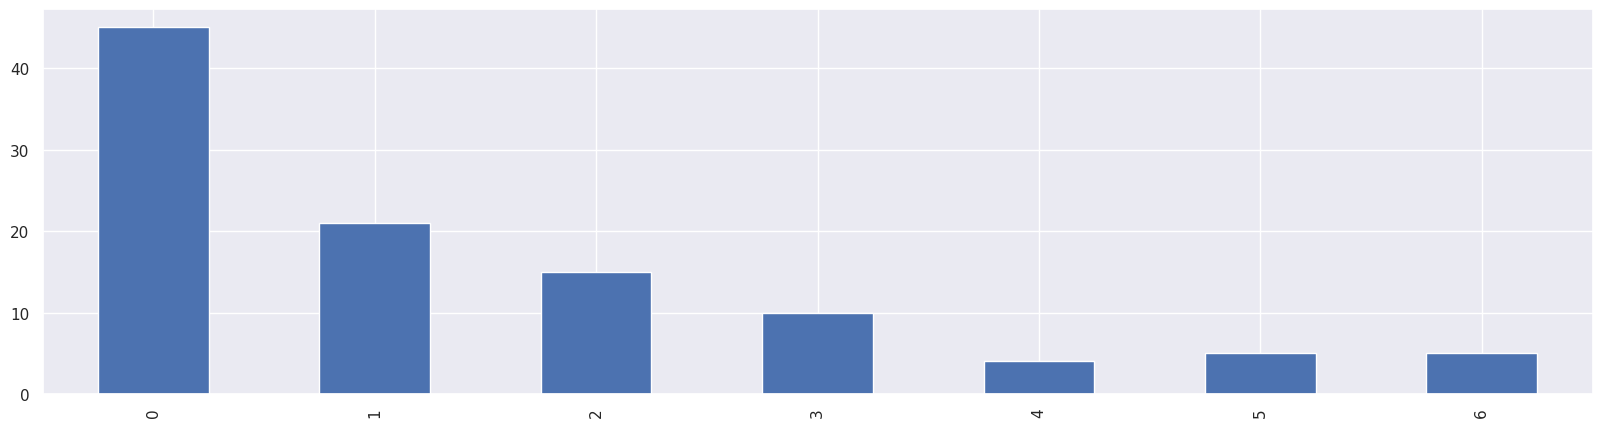

In [46]:
# For a given bar and a given instrument, we expect to see as number of trades between 0 and X,
# where X is the maximum number of child orders per bar.
bar_ccxt_order_aggregation[
    "order_count"
].stack().value_counts().sort_index().plot(kind="bar")

In [47]:
# Display order count by bar.
bar_ccxt_order_aggregation["order_count"]

asset_id,1020313424,1106736216,1670436375,1775391824,1813442534,1871387621,2200033667,2237530510,2470395105,2499295598,2506553600,2565005155,2601760471,2971863517,2989693852,3323452427,3326458212,4417972573,6335759645,8717633868,8968126878
bar_end_datetime,,,,,,,,,,,,,,,,,,,,,
2024-05-17 00:00:00+00:00,0,0,4,0,1,0,2,1,0,0,1,6,3,0,0,0,2,1,0,1,3
2024-05-17 02:00:00+00:00,0,0,2,0,0,0,1,3,2,0,2,0,6,3,0,3,0,0,0,1,1
2024-05-17 04:00:00+00:00,1,4,0,5,1,3,5,5,4,1,0,2,1,0,0,0,1,3,0,1,5
2024-05-17 06:00:00+00:00,2,0,0,3,0,2,0,0,0,2,2,2,0,3,2,3,6,5,2,1,0
2024-05-17 08:00:00+00:00,0,1,0,0,0,0,0,2,0,0,1,1,1,6,1,0,1,6,4,2,0


In [48]:
# If `buy_count` and `sell_count` are both greater than zero for an order,
#  it indicates a bug.
has_buys = ccxt_order_fills["buy_count"] > 0
has_sells = ccxt_order_fills["sell_count"] > 0
# This dataframe should have zero rows.
ccxt_order_fills.loc[has_buys & has_sells].shape[0]

0

In [49]:
# If `buy_count` and `sell_count` are both greater than zero for an instrument and bar,
#  there is likely a bar alignment or timing problem.
has_buys = bar_fills["buy_count"] > 0
has_sells = bar_fills["sell_count"] > 0
# This dataframe should be empty.
bar_fills.loc[has_buys & has_sells].shape[0]

0

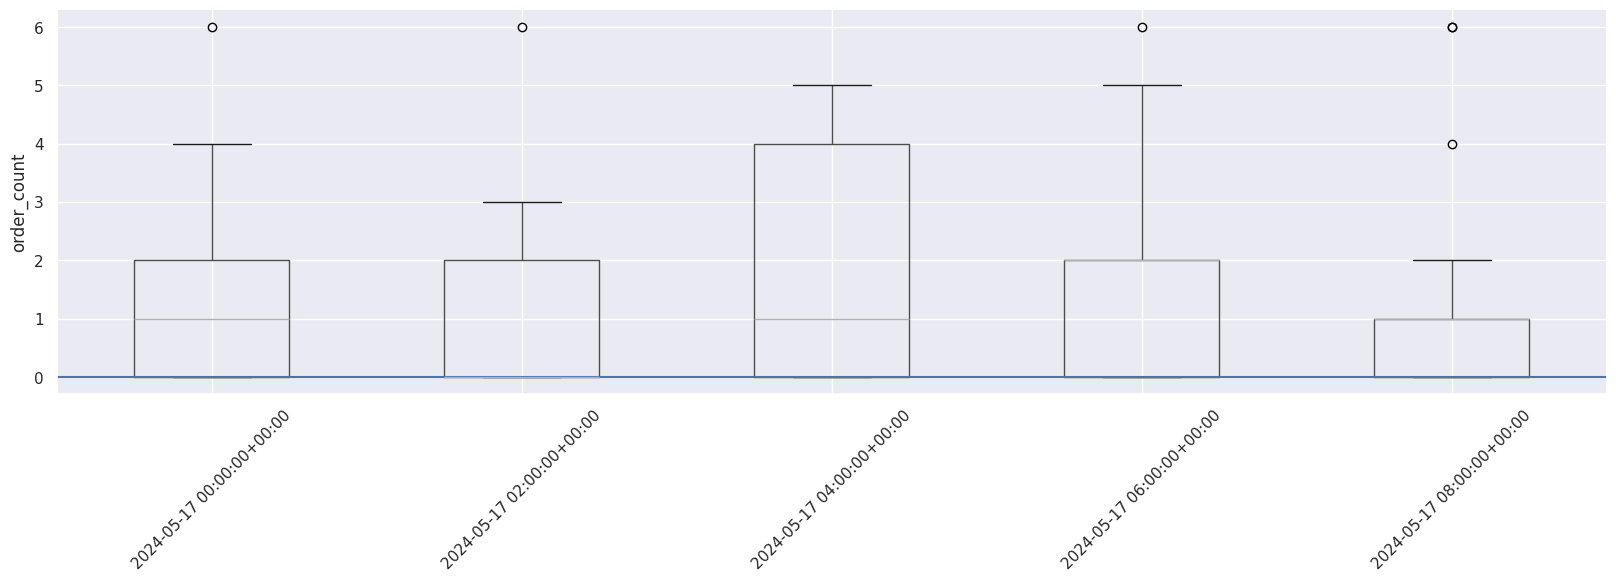

In [50]:
# Plot order counts by timestamp.
col = "order_count"
coplotti.plot_boxplot(bar_ccxt_order_aggregation[col], "by_row", ylabel=col)

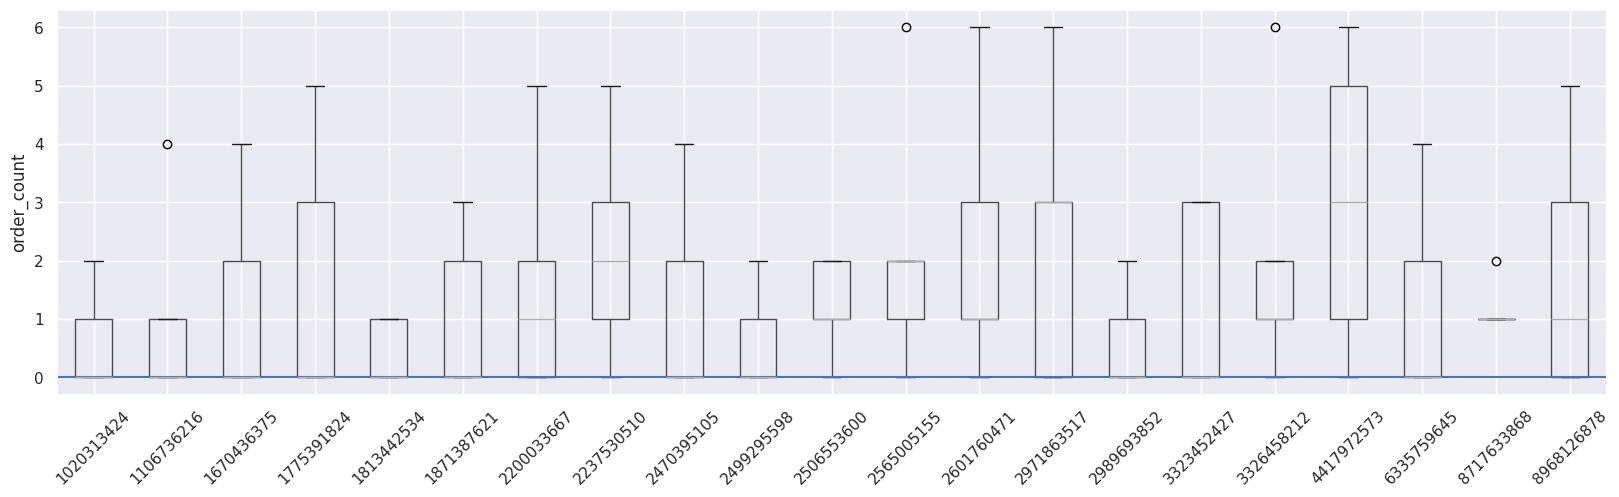

In [51]:
# Plot order counts by asset.
col = "order_count"
coplotti.plot_boxplot(bar_ccxt_order_aggregation[col], "by_col", ylabel=col)

# Fee summary

In [52]:
group_by_col = "is_buy"
obccexqu.generate_fee_summary(fills_df, "is_buy")

is_buy,False,True,combined
fill_count,51.000000,47.000000,98.000000
traded_volume_dollars,3432.906880,3422.407670,6855.314550
fill_fees_dollars,-0.109497,-0.152561,-0.262059
fill_fees_bps,-0.318964,-0.445772,-0.382271
realized_pnl_dollars,9.256620,1.242590,10.499210
realized_pnl_bps,26.964378,3.630748,15.315431
is_buy,0.000000,47.000000,47.000000
is_maker,43.000000,44.000000,87.000000
is_positive_realized_pnl,17.000000,25.000000,42.000000


In [53]:
group_by_col = "is_maker"
obccexqu.generate_fee_summary(fills_df, group_by_col)

is_maker,False,True,combined
fill_count,11.000000,87.00000,98.000000
traded_volume_dollars,433.907400,6421.40715,6855.314550
fill_fees_dollars,0.059011,-0.32107,-0.262059
fill_fees_bps,1.359999,-0.50000,-0.382271
realized_pnl_dollars,-0.025200,10.52441,10.499210
realized_pnl_bps,-0.580769,16.38957,15.315431
is_buy,3.000000,44.00000,47.000000
is_maker,0.000000,87.00000,87.000000
is_positive_realized_pnl,0.000000,42.00000,42.000000


In [54]:
group_by_col = "is_positive_realized_pnl"
obccexqu.generate_fee_summary(fills_df, group_by_col)

is_positive_realized_pnl,False,True,combined
fill_count,56.000000,42.000000,98.000000
traded_volume_dollars,4166.081350,2689.233200,6855.314550
fill_fees_dollars,-0.127597,-0.134462,-0.262059
fill_fees_bps,-0.306276,-0.500000,-0.382271
realized_pnl_dollars,-7.161440,17.660650,10.499210
realized_pnl_bps,-17.189871,65.671694,15.315431
is_buy,22.000000,25.000000,47.000000
is_maker,45.000000,42.000000,87.000000
is_positive_realized_pnl,0.000000,42.000000,42.000000


In [55]:
group_by_col = "wave_id"
obccexqu.generate_fee_summary(fills_df, group_by_col)

wave_id,0,1,2,3,4,5,6,combined
fill_count,22.000000,35.000000,12.000000,8.000000,5.000000,15.000000,1.000000,98.000000
traded_volume_dollars,1193.001300,2492.968350,1057.691410,622.306500,440.109870,948.343820,100.893300,6855.314550
fill_fees_dollars,-0.059650,-0.081055,-0.034326,-0.031115,-0.022005,-0.028863,-0.005045,-0.262059
fill_fees_bps,-0.500000,-0.325134,-0.324533,-0.500000,-0.500000,-0.304350,-0.500000,-0.382271
realized_pnl_dollars,1.886770,1.125780,1.131070,-0.322300,2.709050,3.968840,0.000000,10.499210
realized_pnl_bps,15.815322,4.515821,10.693762,-5.179120,61.553948,41.850223,0.000000,15.315431
is_buy,20.000000,13.000000,8.000000,3.000000,0.000000,3.000000,0.000000,47.000000
is_maker,22.000000,30.000000,9.000000,8.000000,5.000000,12.000000,1.000000,87.000000
is_positive_realized_pnl,17.000000,7.000000,3.000000,2.000000,3.000000,10.000000,0.000000,42.000000


In [56]:
# Get by-wave summary for the test asset.
test_fills = fills_df[fills_df["asset_id"] == test_asset_id]
group_by_col = "wave_id"
obccexqu.generate_fee_summary(test_fills, group_by_col)

wave_id,1,combined
fill_count,2.000000,2.000000
traded_volume_dollars,199.729440,199.729440
fill_fees_dollars,-0.009986,-0.009986
fill_fees_bps,-0.500000,-0.500000
realized_pnl_dollars,-0.144160,-0.144160
realized_pnl_bps,-7.217764,-7.217764
is_buy,1.000000,1.000000
is_maker,2.000000,2.000000
is_positive_realized_pnl,0.000000,0.000000


# Time to fill

## ECDFs

<Axes: xlabel='secs_to_fill'>

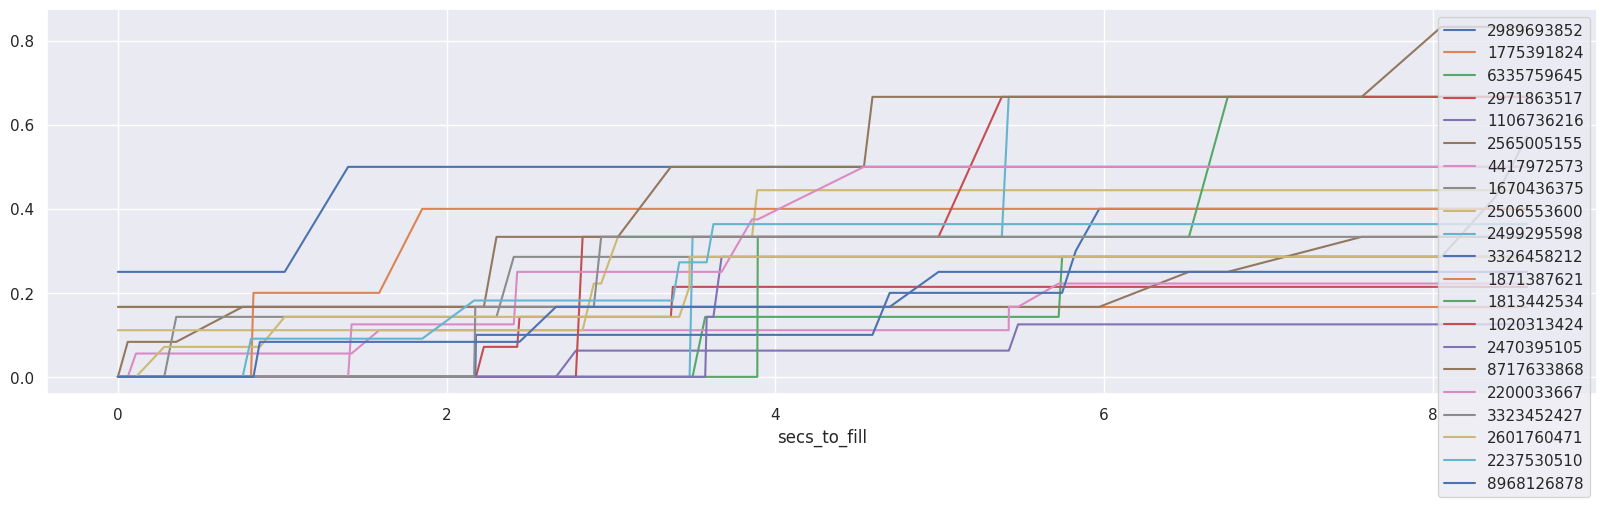

In [57]:
# Compute and plot time to fill ECDFs.
adj_fill_ecdfs = obccexqu.compute_adj_fill_ecdfs(
    fills_df, ccxt_order_response_df, child_order_df
)
adj_fill_ecdfs.plot()

INFO  All trades for wave_id=6 were conducted immediately (with rounding)


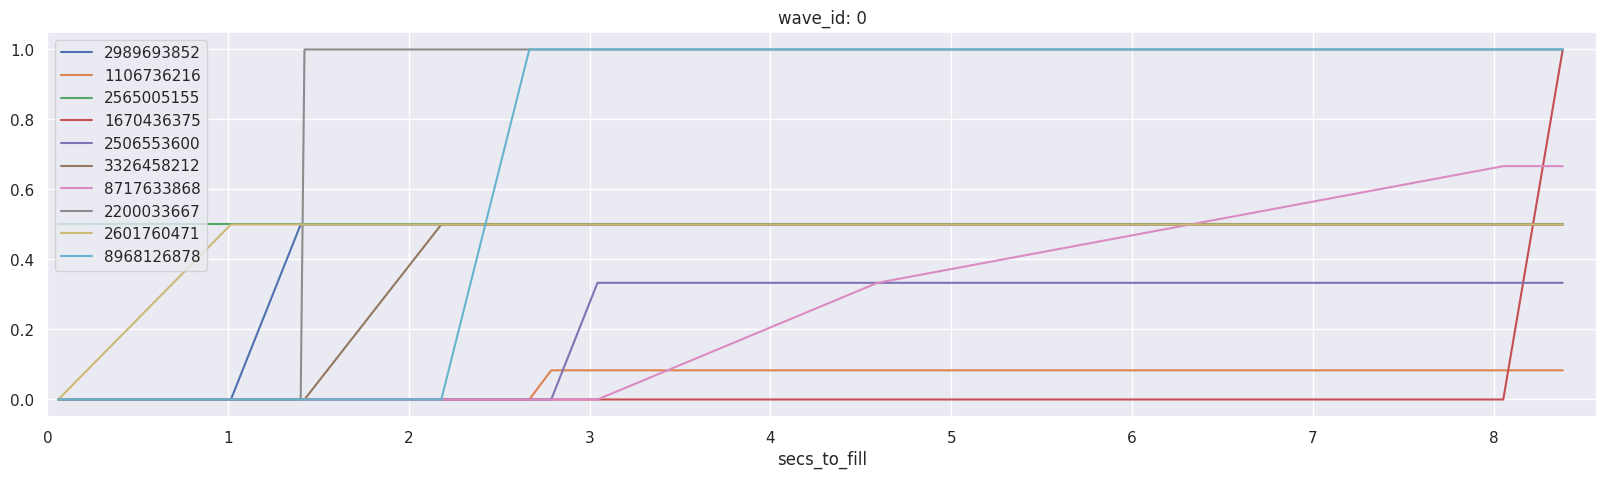

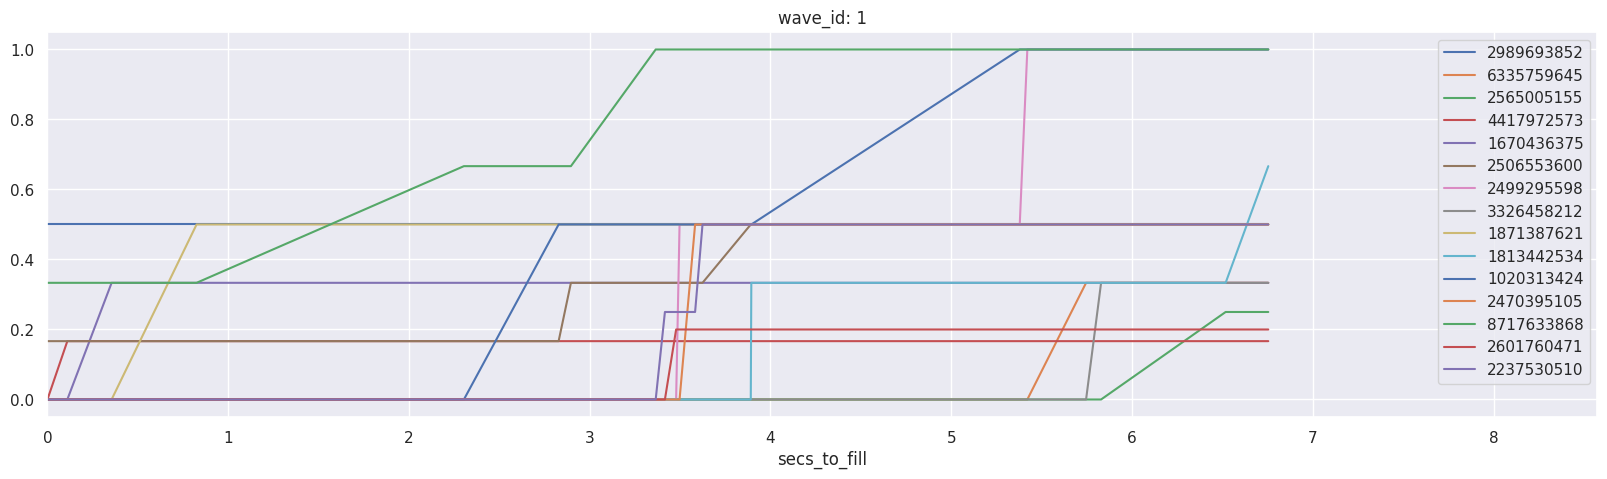

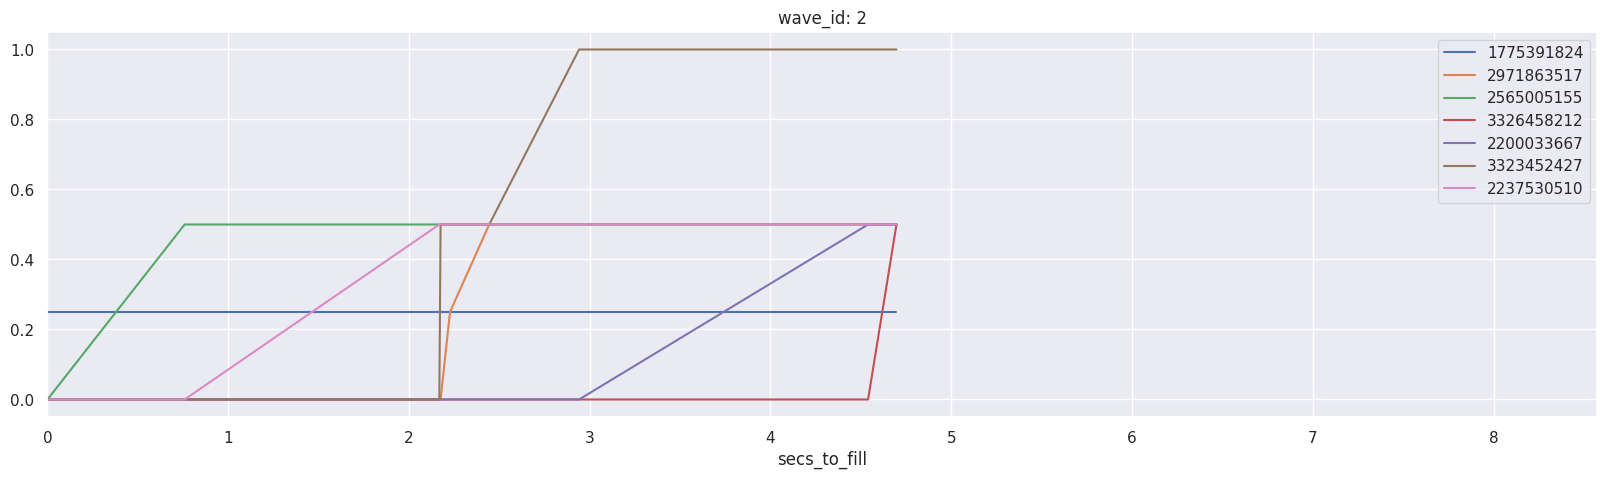

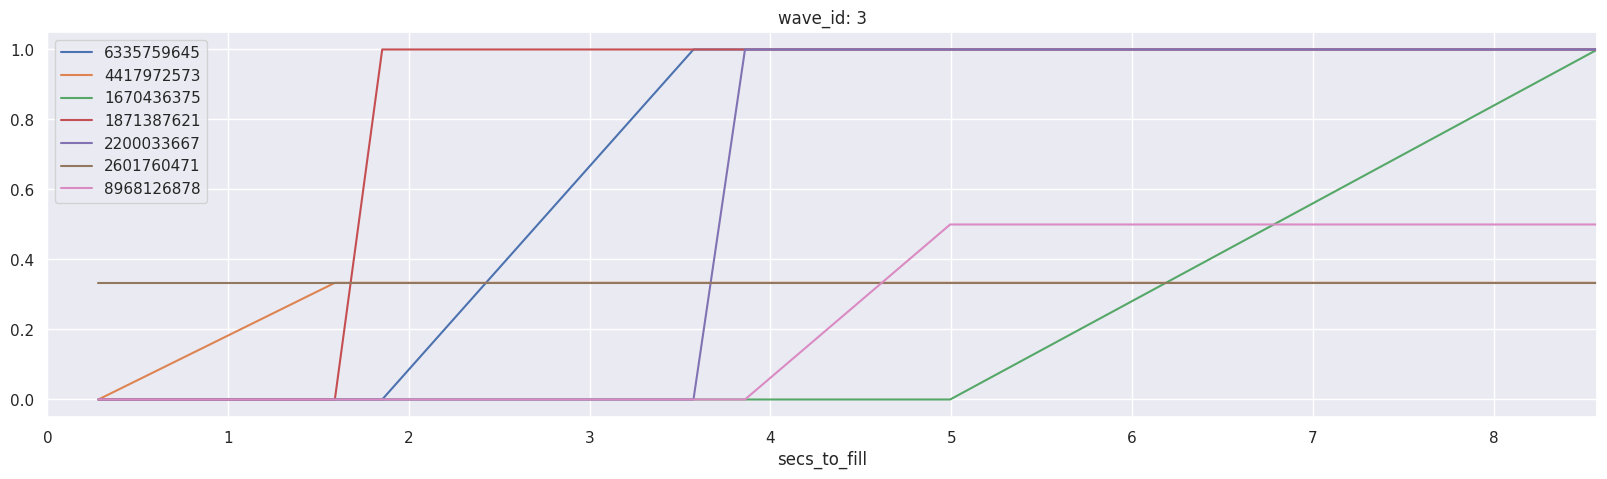

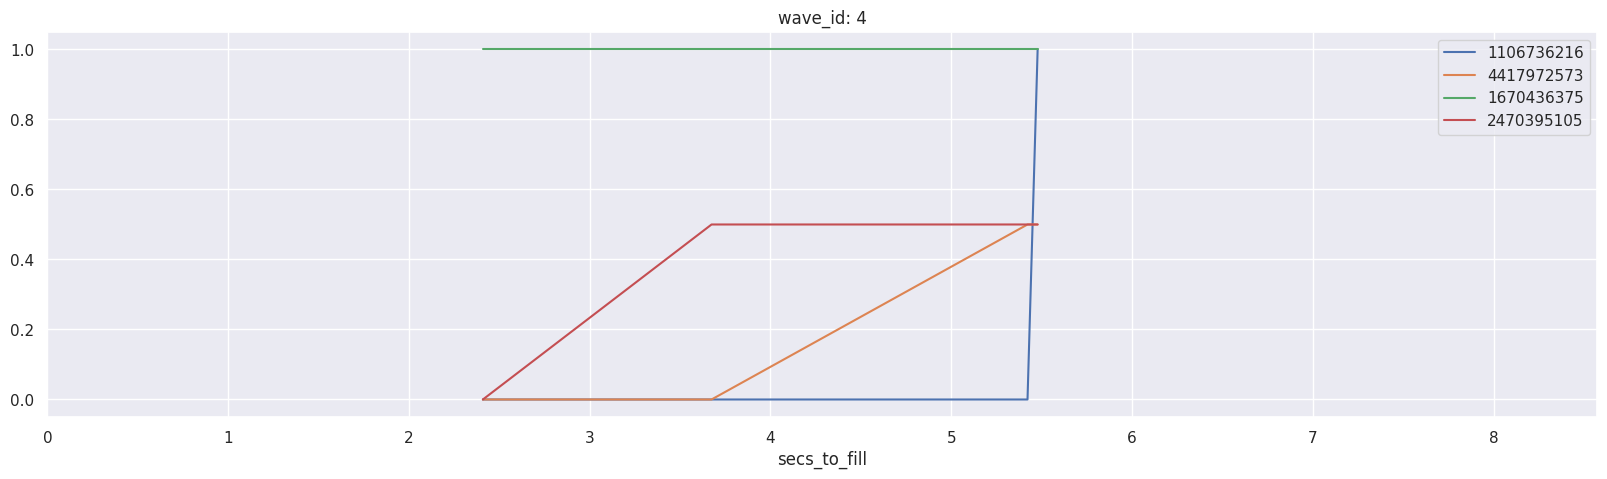

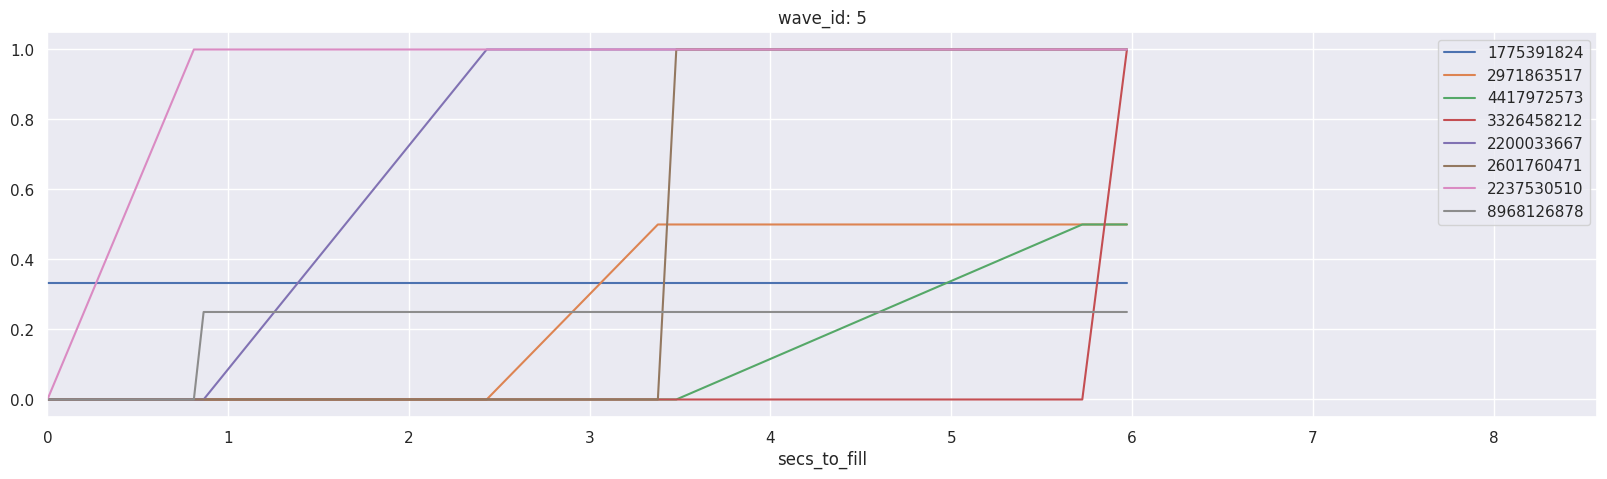

In [58]:
# Plot ECDFs by child order wave.
if "wave_id" in child_order_df.columns:
    cplexsta.plot_adj_fill_ecdfs(
        fills_df,
        ccxt_order_response_df,
        child_order_df,
    )

## Average order lifespan in seconds

In [59]:
# TODO: All of these calculations should be factored out (and their accuracy checked).

# Map symbol to asset ID.
ccxt_fills["asset_id"] = ccxt_fills["symbol"].apply(
    lambda x: symbol_to_asset_id_mapping[x]
)
# Convert `datetime` column from string to timestamp.
ccxt_fills["datetime"] = ccxt_fills["datetime"].apply(
    lambda x: pd.to_datetime(x, utc=True)
)

In [60]:
# `datetime` is the time the order appeared on the exchange.
# `order_update_datetime` is the time the order was closed.
# Calculate average order lifespan by asset based on the exchange data.
ccxt_fills["lifespan_in_seconds"] = (
    ccxt_fills["order_update_datetime"] - ccxt_fills["datetime"]
).apply(lambda x: x.total_seconds())
ccxt_fills.groupby("asset_id").apply(lambda x: x["lifespan_in_seconds"].mean())

asset_id
1020313424    5.637667
1106736216    7.323600
1670436375    6.986000
1775391824    6.803250
1813442534    5.790000
1871387621    5.914800
2200033667    6.640750
2237530510    6.708000
2470395105    7.332500
2499295598    5.874667
2506553600    4.956667
2565005155    7.081636
2601760471    6.769545
2971863517    7.439000
2989693852    3.304667
3323452427    6.751333
3326458212    7.184900
4417972573    7.466067
6335759645    7.576000
8717633868    4.517500
8968126878    6.883778
dtype: float64

In [61]:
order_to_lifespan = ccxt_fills.set_index("order")["lifespan_in_seconds"].to_dict()
child_order_df["lifespan_in_seconds"] = child_order_df["ccxt_id"].apply(
    lambda x: order_to_lifespan.get(x)
)

# Execution quality

## Compute `target_position_df` and `portfolio_df`

In [62]:
price_df = ohlcv_bars[price_col]
target_position_df = oororcon.convert_order_df_to_target_position_df(
    parent_order_df,
    price_df,
)
hpandas.df_to_str(target_position_df, num_rows=6, log_level=logging.INFO)

holdings_notional                                                                                                                                                                                                                             holdings_shares                                                                                                                                                                                                                                  price                                                                                                                                                                                                                             target_holdings_notional                                                                                                                                                                                                                                target_holdings_shares                                                                                                                                                                                                                                target_trades_notional                                                                                                                                                                                                                             target_trades_shares                                                                                                                                                                                                                            
                                 1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878      1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878 1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878               1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471    2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878             1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471    2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878             1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878           1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [63]:
portfolio_df = obccexqu.convert_bar_fills_to_portfolio_df(
    bar_fills,
    price_df,
)
hpandas.df_to_str(portfolio_df, num_rows=6, log_level=logging.INFO)

holdings_shares                                                                                                                                                                                                                             holdings_notional                                                                                                                                                                                                                             executed_trades_shares                                                                                                                                                                                                                             executed_trades_notional                                                                                                                                                                                                                                    pnl                                                                                                                                                                                                                            
asset_id                       1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878        1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878             1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878               1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878 1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878
2024-05-16 22:00:00+00:00             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN               NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                      NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2024-05-17 00:00:00+00:00             0.0        0.0       -7.1        0.0     -333.0        0.0       -0.9        1.0        0.0        0.0       -4.3      -51.0      -6.34        0.0        0.0        0.0       97.6      -61.0        0.0       -1.0      -0.18               0.0        0.0  -100.0461        0.0 -100.95894        0.0   -96.9138    159.303        0.0  

## PNL and price for the test asset

<Axes: >

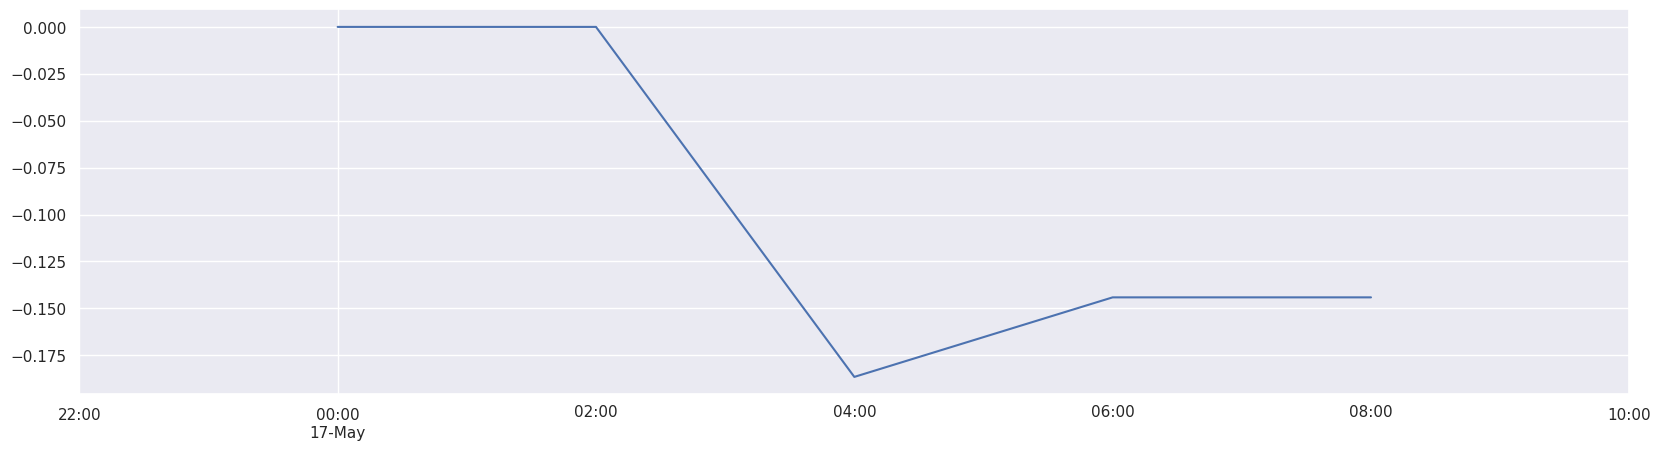

In [64]:
portfolio_df["pnl"][test_asset_id].cumsum().plot()

<Axes: xlabel='end_timestamp'>

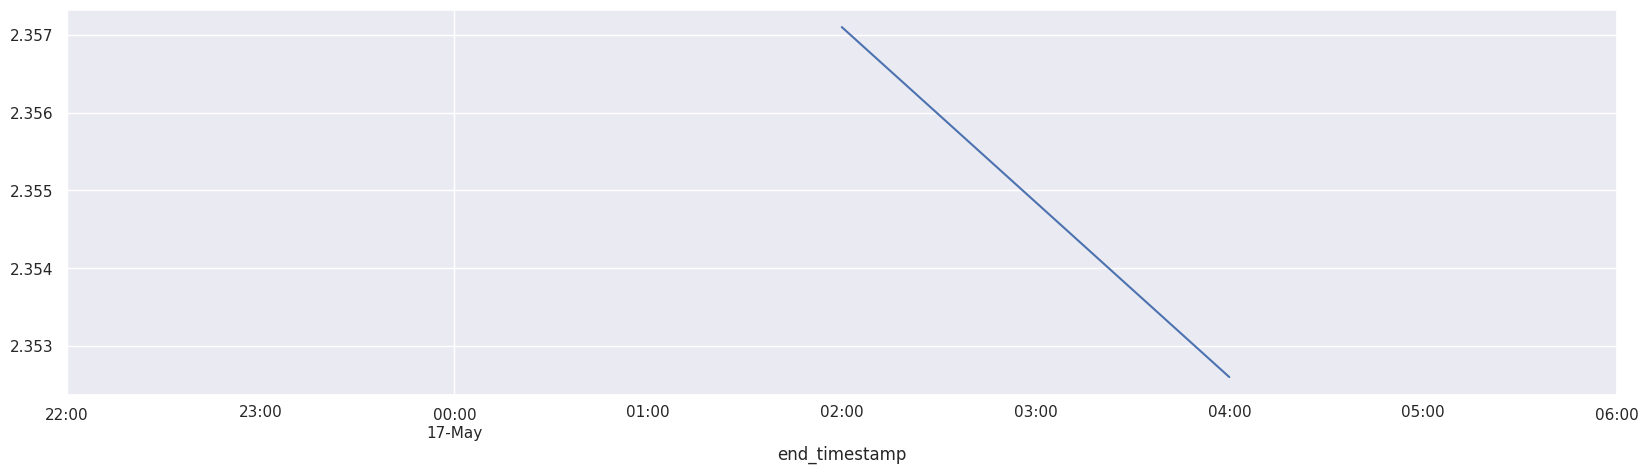

In [65]:
target_position_df["price"][test_asset_id].plot()

## Compute execution quality

In [66]:
(
    execution_quality_df,
    execution_quality_stats_df,
) = cftpdp.compute_execution_quality_df(
    portfolio_df,
    target_position_df,
)
hpandas.df_to_str(execution_quality_df, num_rows=6, log_level=logging.INFO)
hpandas.df_to_str(execution_quality_stats_df, num_rows=6, log_level=logging.INFO)

/app/amp/core/finance/portfolio_df_processing/slippage.py:97: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  1e4 * side * holdings_price_per_share.pct_change().shift(-1)


executed_trades_shares                                                                                                                                                                                                                              fill_rate                                                                                                                                                                                                                             underfill_share_count                                                                                                                                                                                                                             underfill_notional                                                                                                                                                                                                                             underfill_opportunity_cost_realized_notional                                                                                                                                                                                                                             underfill_opportunity_cost_notional                                                                                                                                                                                                                             tracking_error_shares                                                                                                                                                                                                                             tracking_error_notional                                                                                                                                                                                                                             tracking_error_bps                                                                                                                                                                                                                                      is_buy                                                                                                                                                                                                                                is_sell                                                                                                                                                                                                                             is_benchmark_profitable                                                                                                                                                                                                                             holdings_price_per_share                                                                                                                                                                                                                             trade_price_per_share                                                                                                                                                                                                                             slippage_notional                                                                                                                                                                                                                             slippage_notional_per_share                                                                                                                                                                                                                             slippage_in_bps                                                                                                    

,slippage_notional,underfill_opportunity_cost_realized_notional,pnl,gross_volume,net_volume,gmv,nmv
2024-05-16 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-17 00:00:00+00:00,-0.25304,NaN,0.89916,1094.92316,-576.87236,1094.38592,-575.9732
2024-05-17 02:00:00+00:00,0.88049,0.0,3.16737,1276.95466,520.14742,1057.98991,-52.65841
,...,...,...,...,...,...,...
2024-05-17 06:00:00+00:00,0.33132,0.0,4.49474,1507.06658,-804.0764,1113.28699,-910.32523
2024-05-17 08:00:00+00:00,NaN,NaN,0.32713,1112.0433,909.9981,0.0,-0.0
2024-05-17 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
execution_quality_df.columns.levels[0].to_list()

['benchmark_return_in_bps',
 'benchmark_return_notional',
 'executed_trades_shares',
 'fill_rate',
 'holdings_price_per_share',
 'is_benchmark_profitable',
 'is_buy',
 'is_sell',
 'slippage_in_bps',
 'slippage_notional',
 'slippage_notional_per_share',
 'tracking_error_bps',
 'tracking_error_notional',
 'tracking_error_shares',
 'trade_price_per_share',
 'underfill_notional',
 'underfill_opportunity_cost_notional',
 'underfill_opportunity_cost_realized_notional',
 'underfill_share_count']

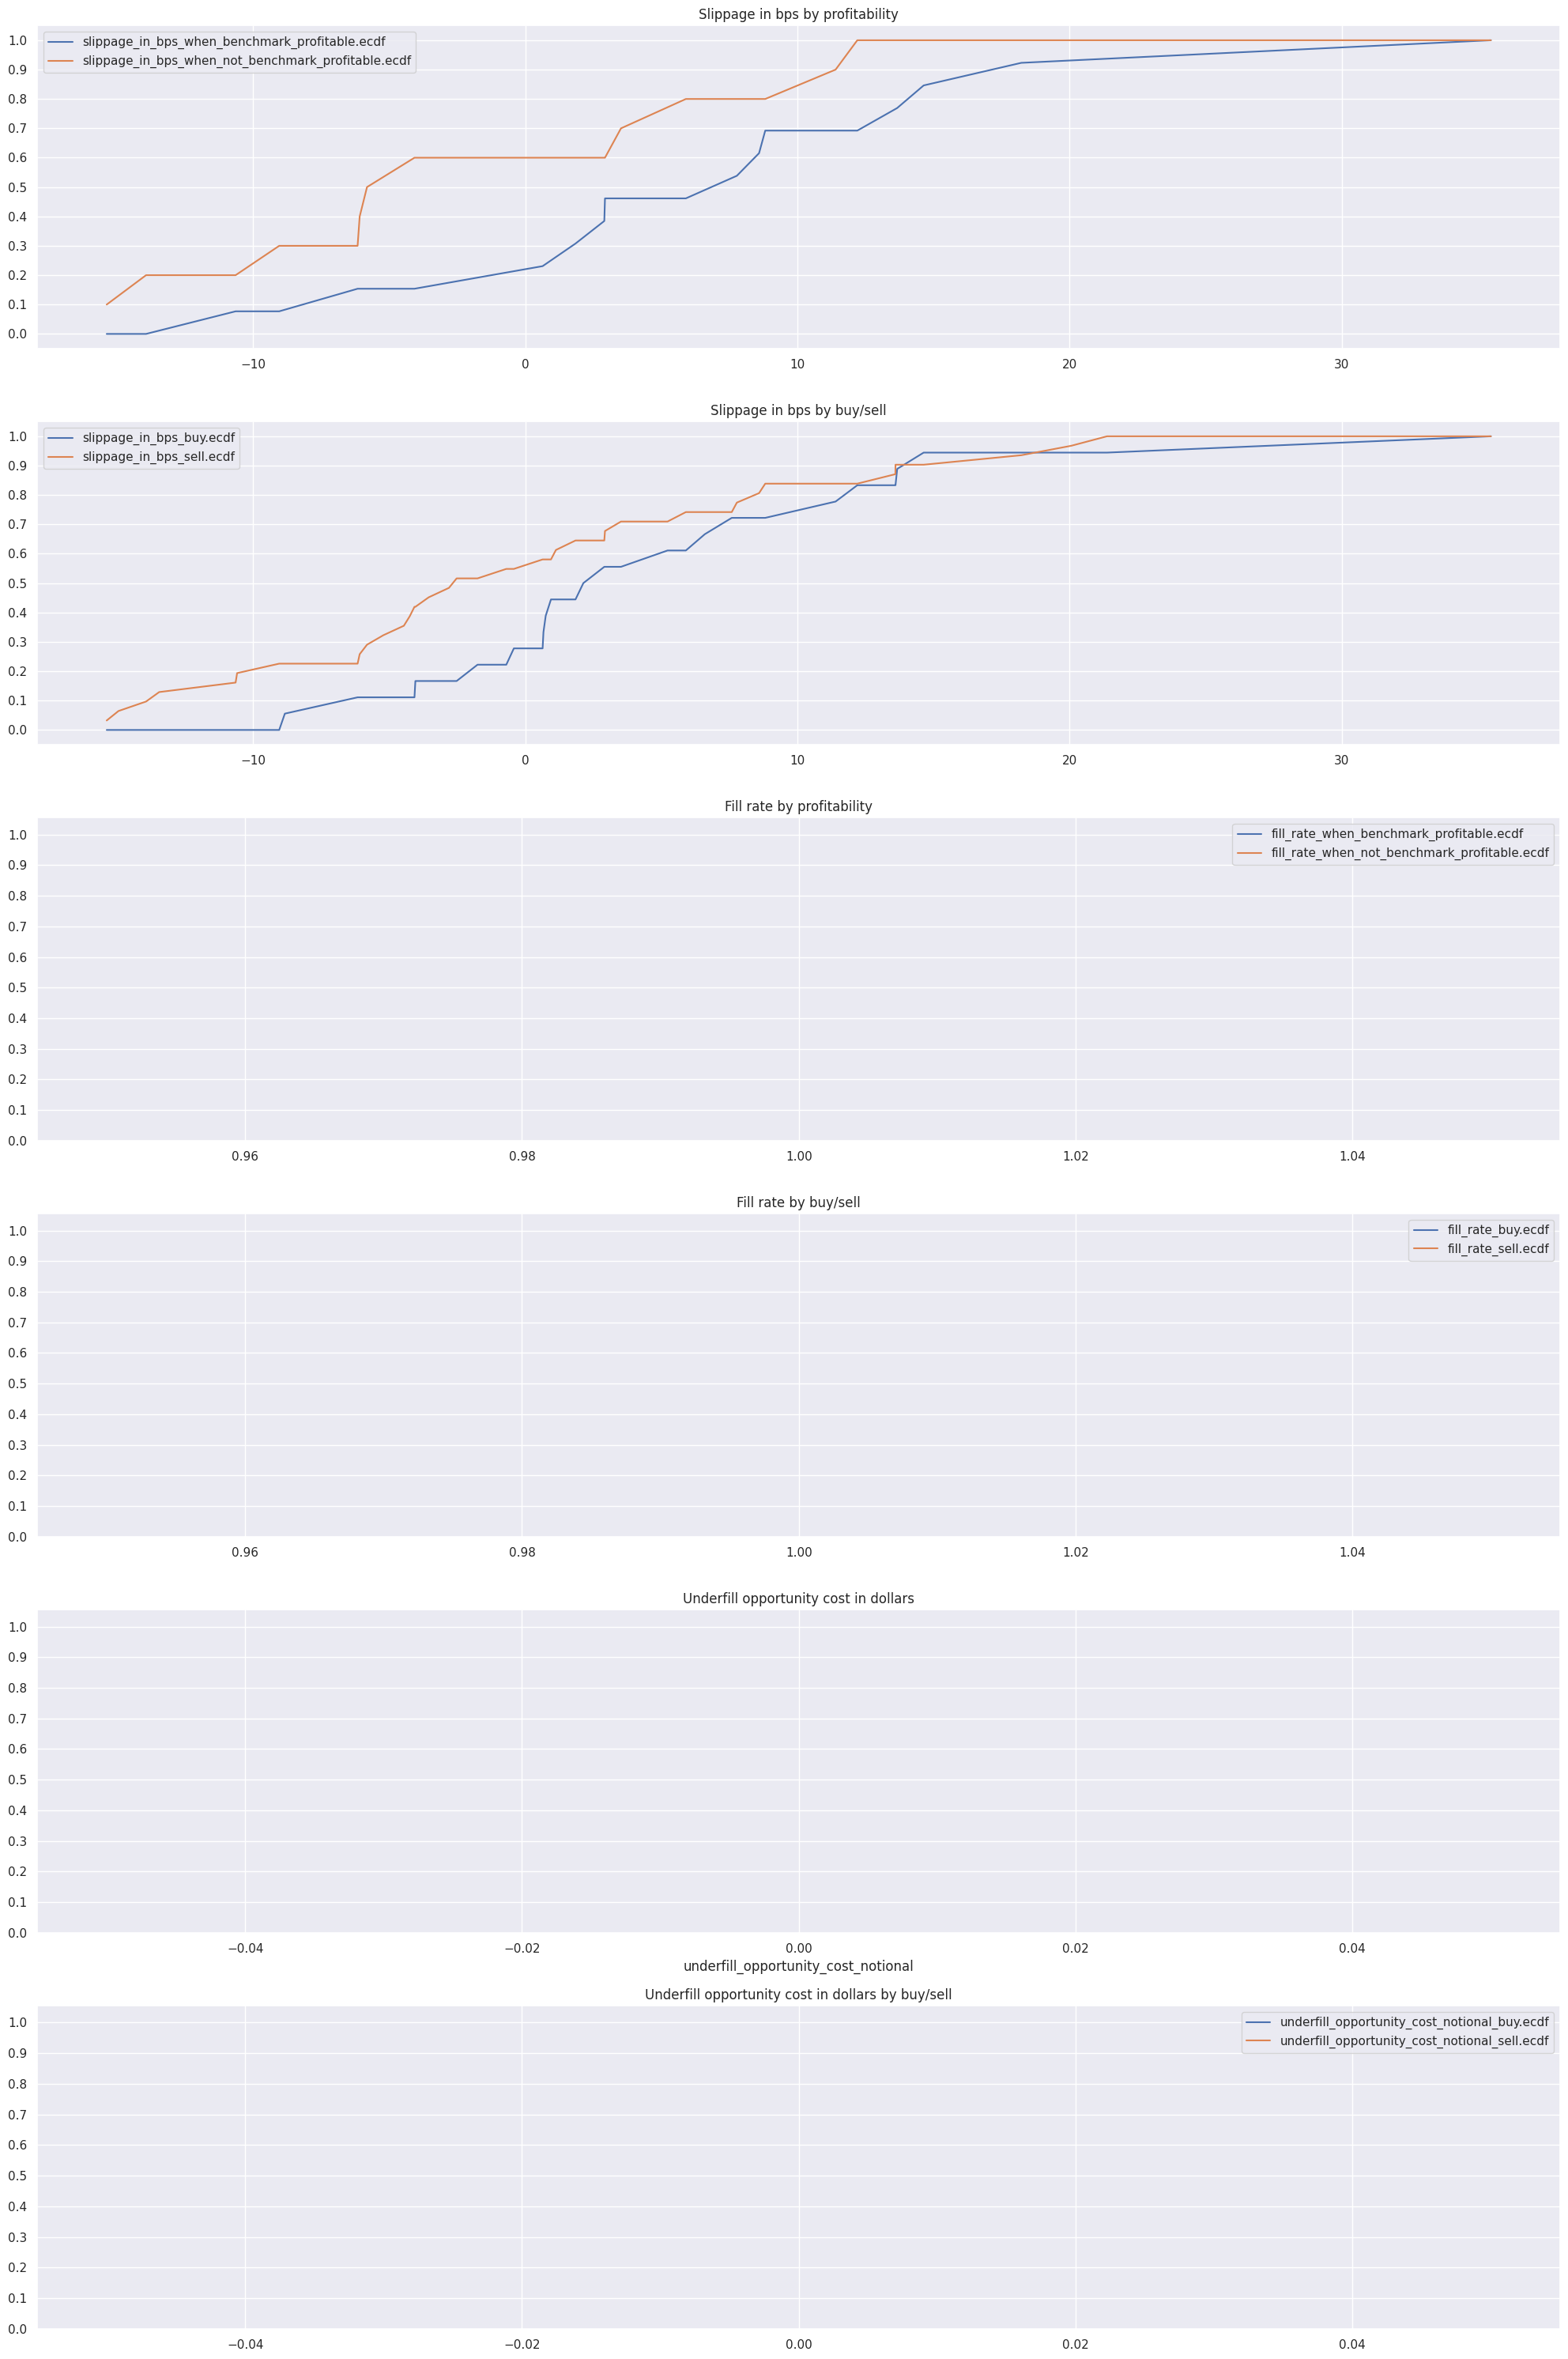

In [68]:
coplotti.plot_execution_ecdfs(execution_quality_df)

## Compute and plot portfolio stats

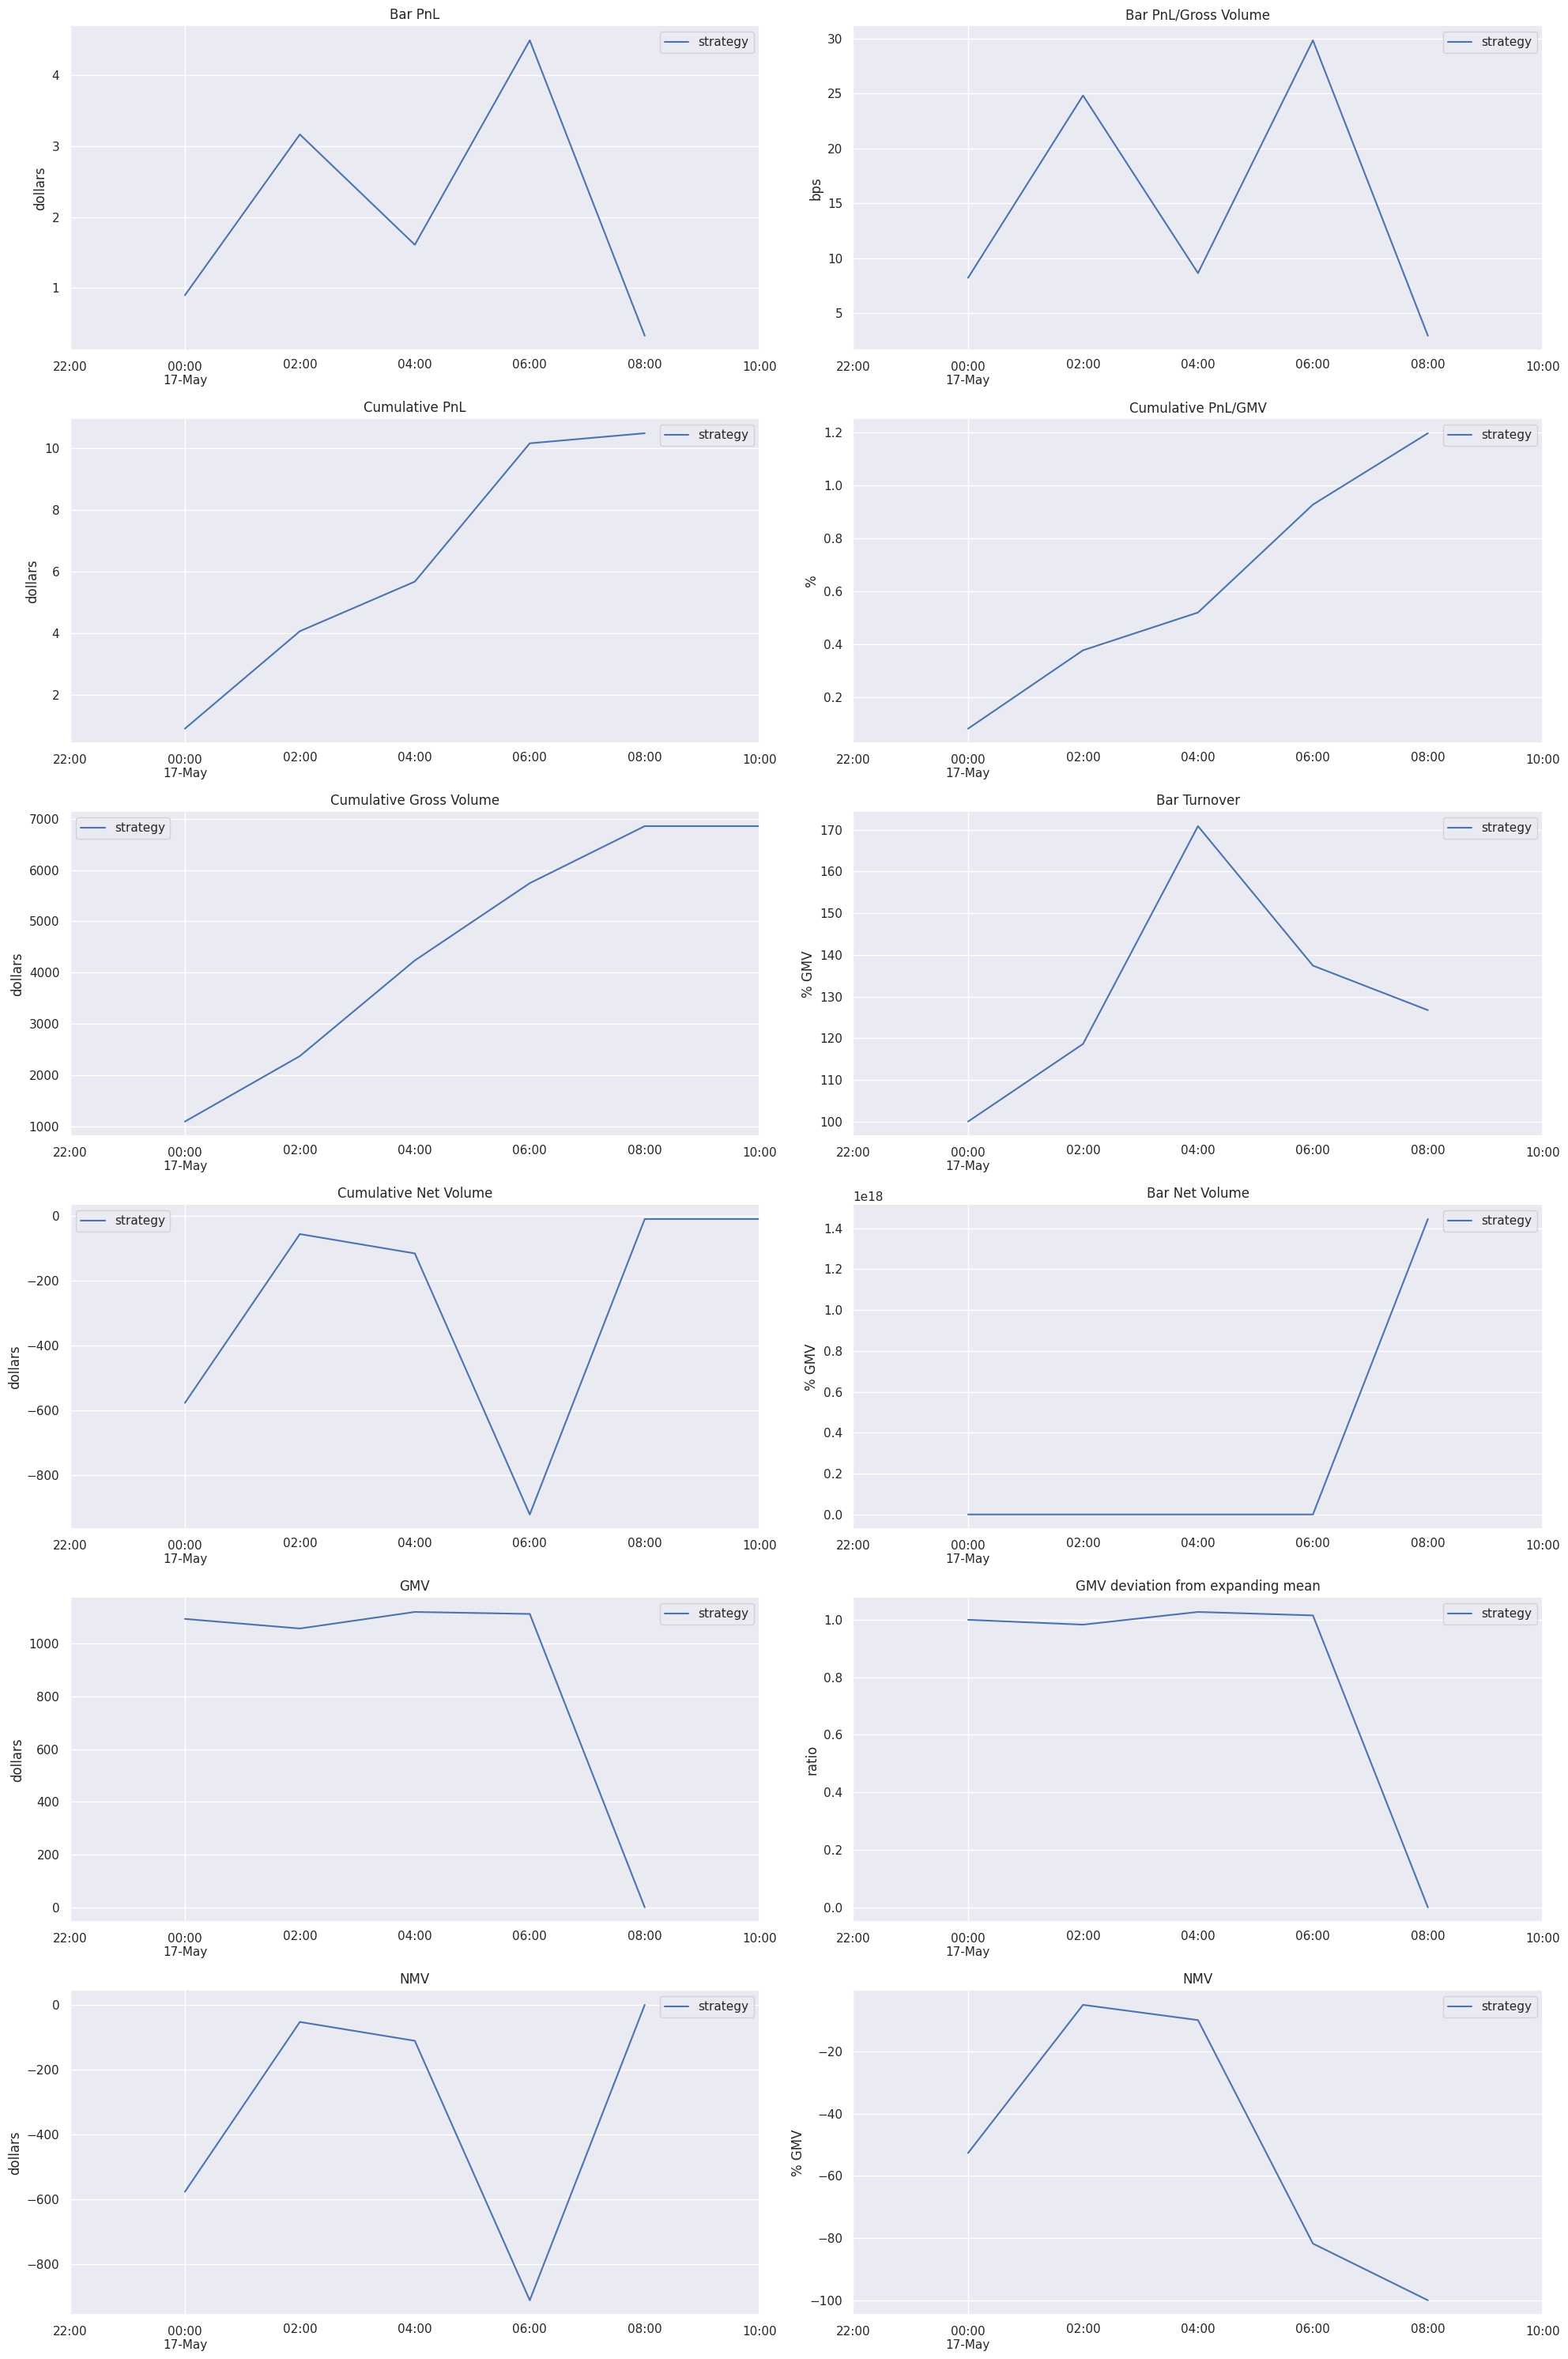

In [69]:
coplotti.plot_portfolio_stats(execution_quality_stats_df)

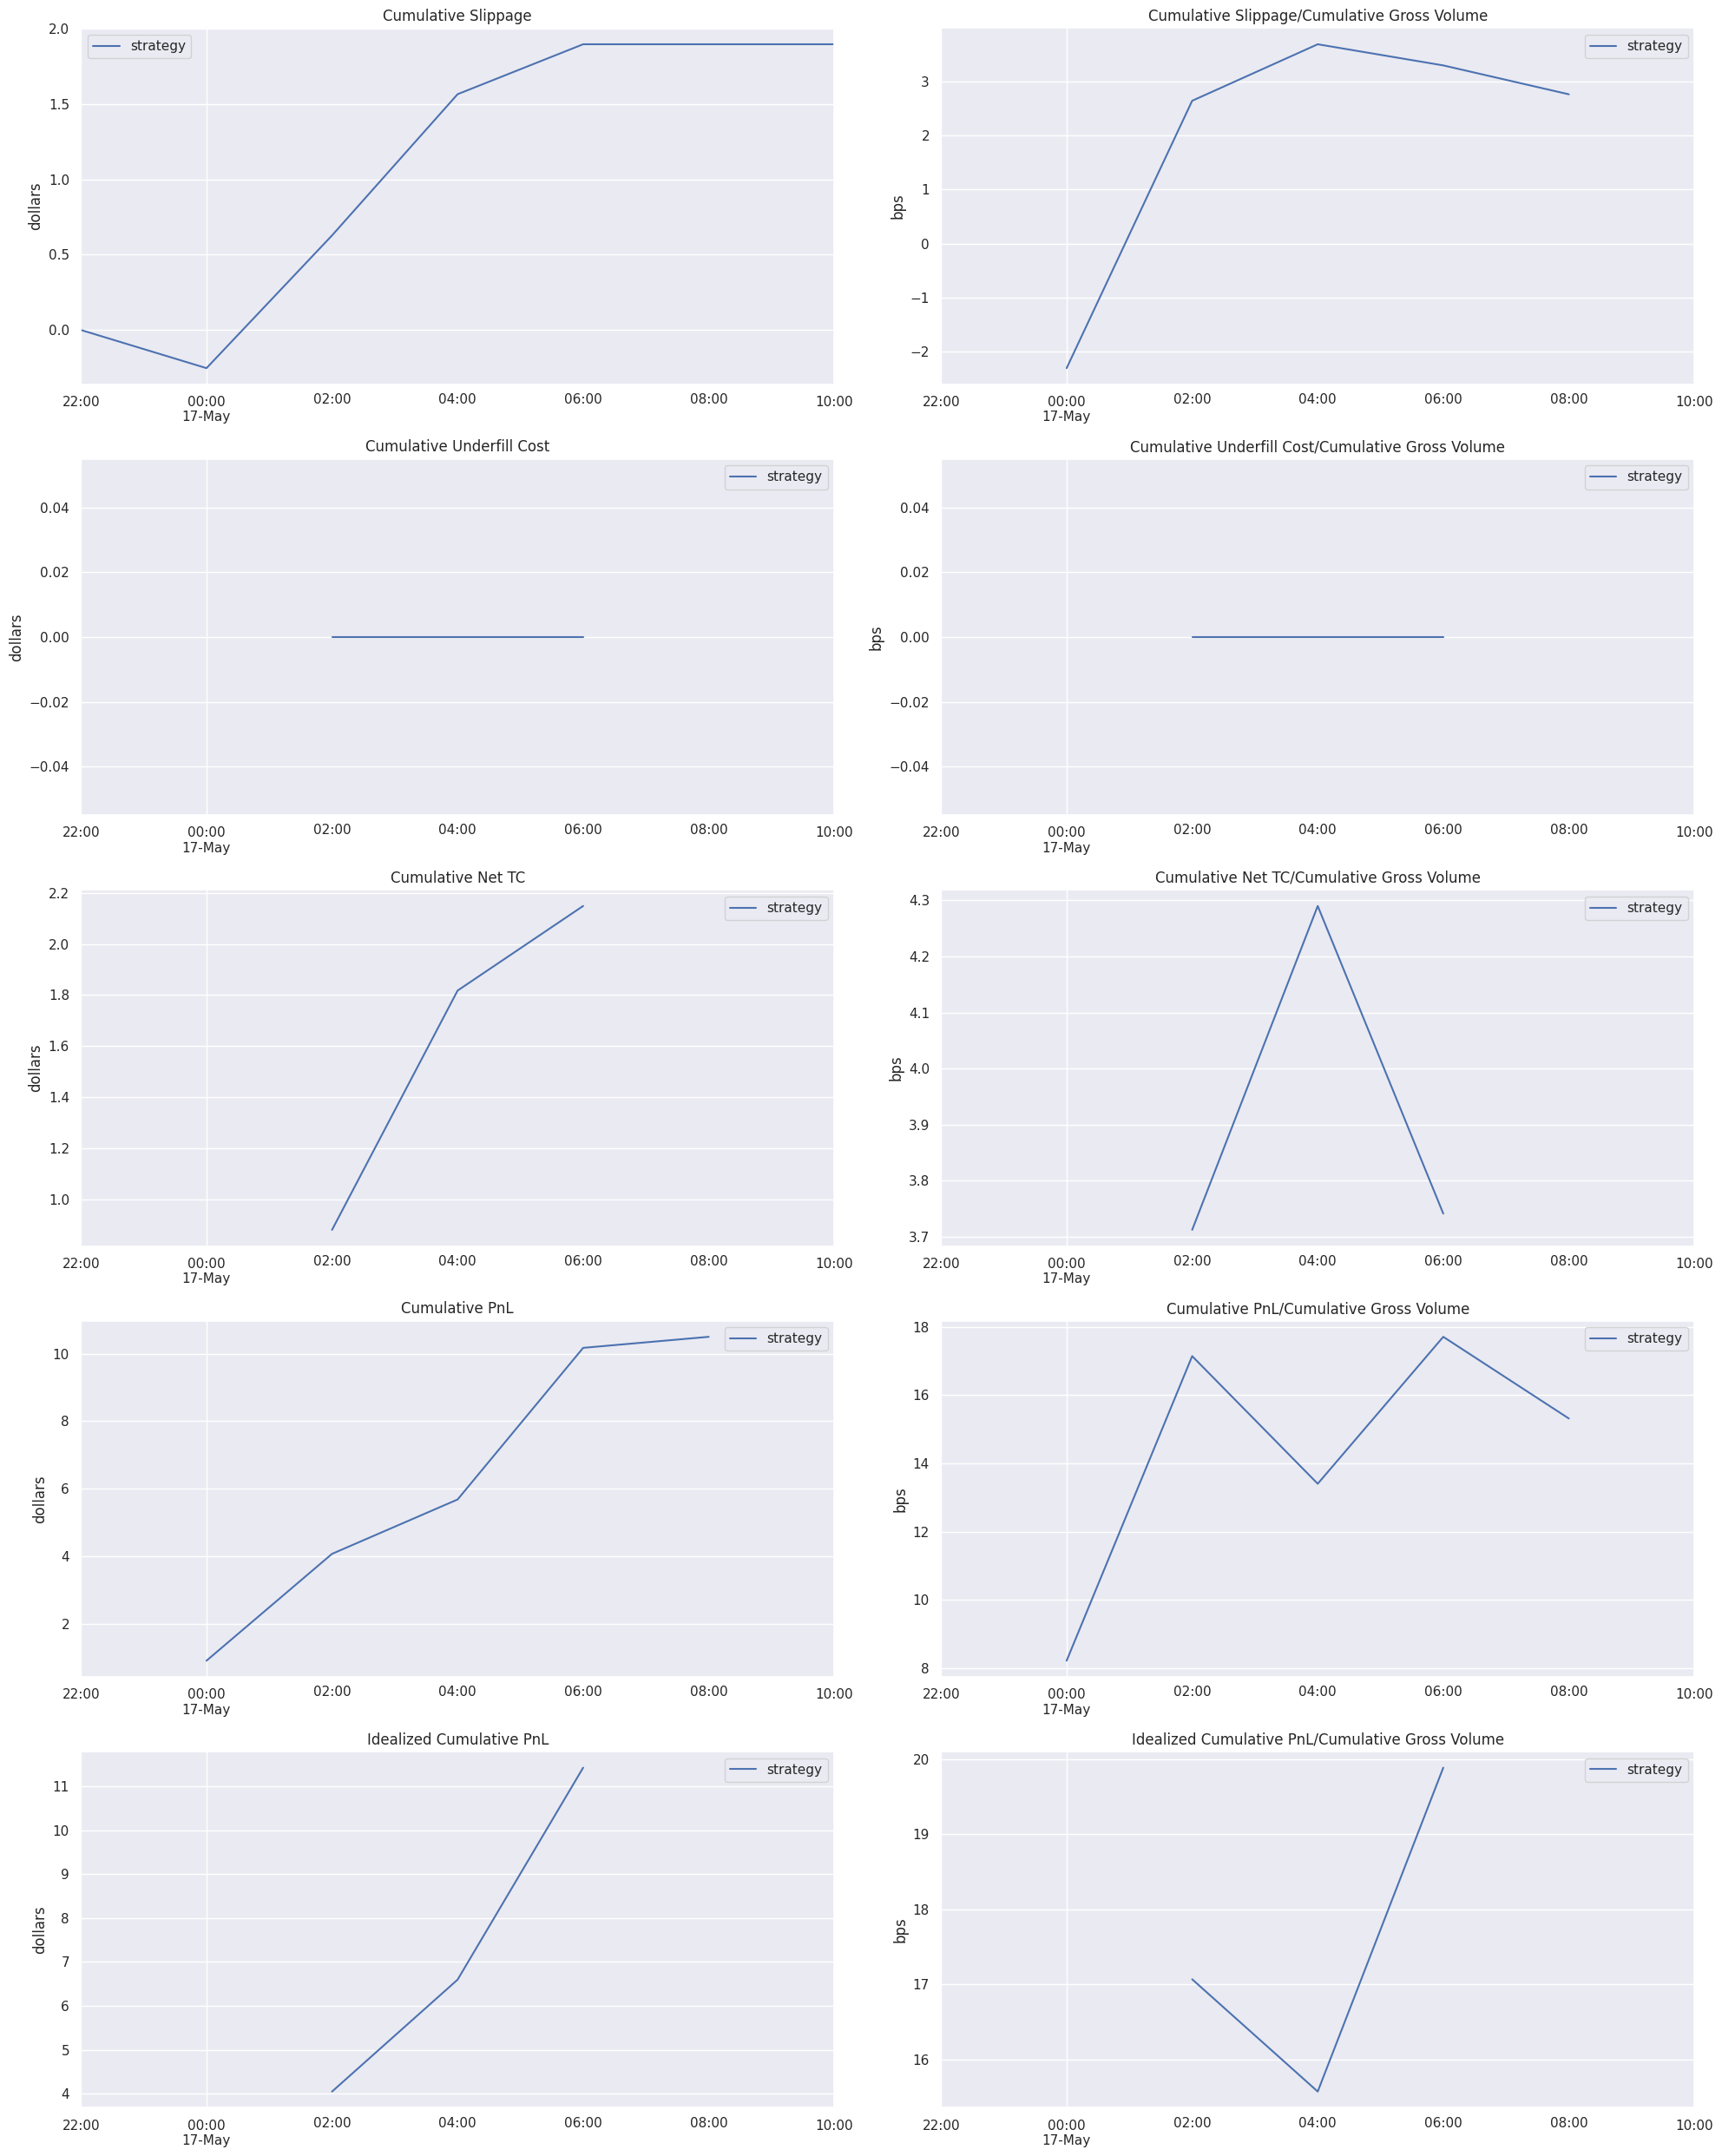

In [70]:
coplotti.plot_execution_stats(execution_quality_stats_df)

##  Filled order execution quality

In [71]:
filled_order_execution_quality = obccexqu.compute_filled_order_execution_quality(
    filled_ccxt_orders, tick_decimals=6
)
hpandas.df_to_str(
    filled_order_execution_quality, num_rows=6, log_level=logging.INFO
)

,direction,price_improvement_notional,price_improvement_bps,underfill_quantity,underfill_pct,underfill_notional_at_limit_price,underfill_notional_at_transaction_price
10536850655,1,0.0,0.0,0.0,0.0,0.0,0.0
10537585230,-1,0.0,0.0,0.0,0.0,0.0,0.0
4214087518,-1,0.0,0.0,0.0,0.0,0.0,0.0
,...,...,...,...,...,...,...
55932218900,-1,0.0,0.0,0.0,0.0,0.0,0.0
55933213181,1,0.0,0.0,0.0,0.0,0.0,0.0
55934329092,-1,0.0,0.0,-0.0,-0.0,-0.0,-0.0


In [72]:
filled_order_execution_quality.describe()

,direction,price_improvement_notional,price_improvement_bps,underfill_quantity,underfill_pct,underfill_notional_at_limit_price,underfill_notional_at_transaction_price
count,63.000000,63.000000,63.000000,6.300000e+01,6.300000e+01,6.300000e+01,6.300000e+01
mean,-0.079365,0.000103,0.077260,1.412698e-01,3.221800e-02,3.187311e+00,3.187311e+00
std,1.004853,0.000548,0.313286,7.546918e-01,1.522670e-01,1.503186e+01,1.503186e+01
min,-1.000000,0.000000,0.000000,-1.776357e-15,-1.541976e-16,-2.808243e-14,-2.808243e-14
25%,-1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000,0.004000,1.736385,5.300000e+00,8.888889e-01,8.670080e+01,8.670080e+01


In [73]:
# If any value is negative (up to machine precision), except for `direction`, it indicates a bug.
filled_order_execution_quality.loc[
    (filled_order_execution_quality.drop("direction", axis=1).round(9) < 0).any(
        axis=1
    )
].shape[0]

0

## Compare bar trade prices to OHLCV TWAP

In [74]:
actual_and_ohlcv_price_df = {
    "buy_trade_price": trade_prices["buy_trade_price"],
    "sell_trade_price": trade_prices["sell_trade_price"],
    "twap": ohlcv_bars["twap"],
    "open": ohlcv_bars["open"],
    "high": ohlcv_bars["high"],
    "low": ohlcv_bars["low"],
    "close": ohlcv_bars["close"],
}
actual_and_ohlcv_price_df = pd.concat(actual_and_ohlcv_price_df, axis=1)
hpandas.df_to_str(actual_and_ohlcv_price_df, num_rows=6, log_level=logging.INFO)

buy_trade_price                                                                                                                                                                                                                             sell_trade_price                                                                                                                                                                                                                                   twap                                                                                                                                                                                                                                                                                      open                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                              close                                                                                                                                                                                                                                                                        
                               1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878       1020313424 1106736216 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3323452427 3326458212 4417972573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534   1871387621  2200033667  2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878
2024-05-16 22:00:00+00:00             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN   

<Axes: >

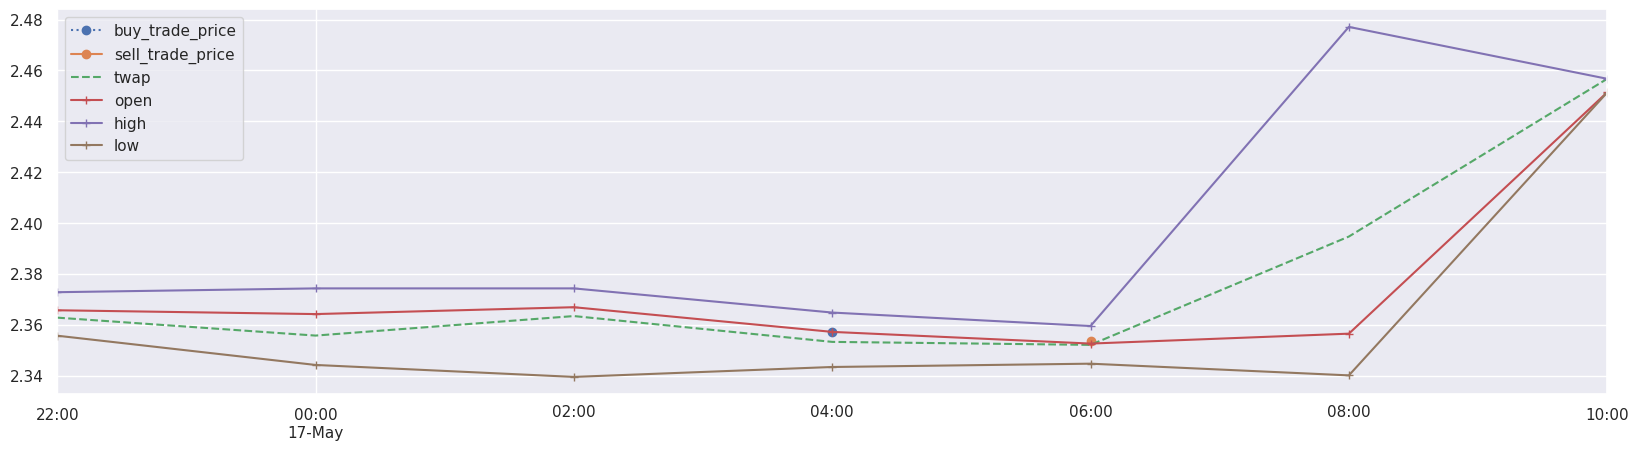

In [75]:
cols = [
    "buy_trade_price",
    "sell_trade_price",
    "twap",
    "open",
    "high",
    "low",
]
cofinanc.get_asset_slice(actual_and_ohlcv_price_df[cols], test_asset_id).plot(
    kind="line", style=["o:", "o-", "--", "+-", "+-", "+-"]
)

## Spread and High-Low Range

### Average bid/ask spread by asset_id

In [76]:
# Display average notional spread per instrument.
mean_spread_notional = (
    child_order_df.groupby("asset_id")["spread"]
    .mean()
    .rename("mean_spread_notional")
)
# Brutally average bps.
mean_spread_bps = (
    child_order_df.groupby("asset_id")["spread_bps"]
    .mean()
    .rename("mean_spread_bps")
)
mean_spreads = pd.concat([mean_spread_notional, mean_spread_bps], axis=1)

In [77]:
mean_spreads.sort_values("mean_spread_bps")

,mean_spread_notional,mean_spread_bps
asset_id,,
2237530510,0.001000,0.062188
2200033667,0.001000,0.092339
8968126878,0.010000,0.175618
8717633868,0.001167,0.336757
1871387621,0.100000,0.373309
1020313424,0.000100,0.424692
2989693852,0.000200,0.463684
3323452427,0.001333,0.490104
2506553600,0.001167,0.493623


<Axes: title={'center': 'Average Spread per Instrument in Basis Points'}, xlabel='Instrument', ylabel='Average Spread (bps)'>

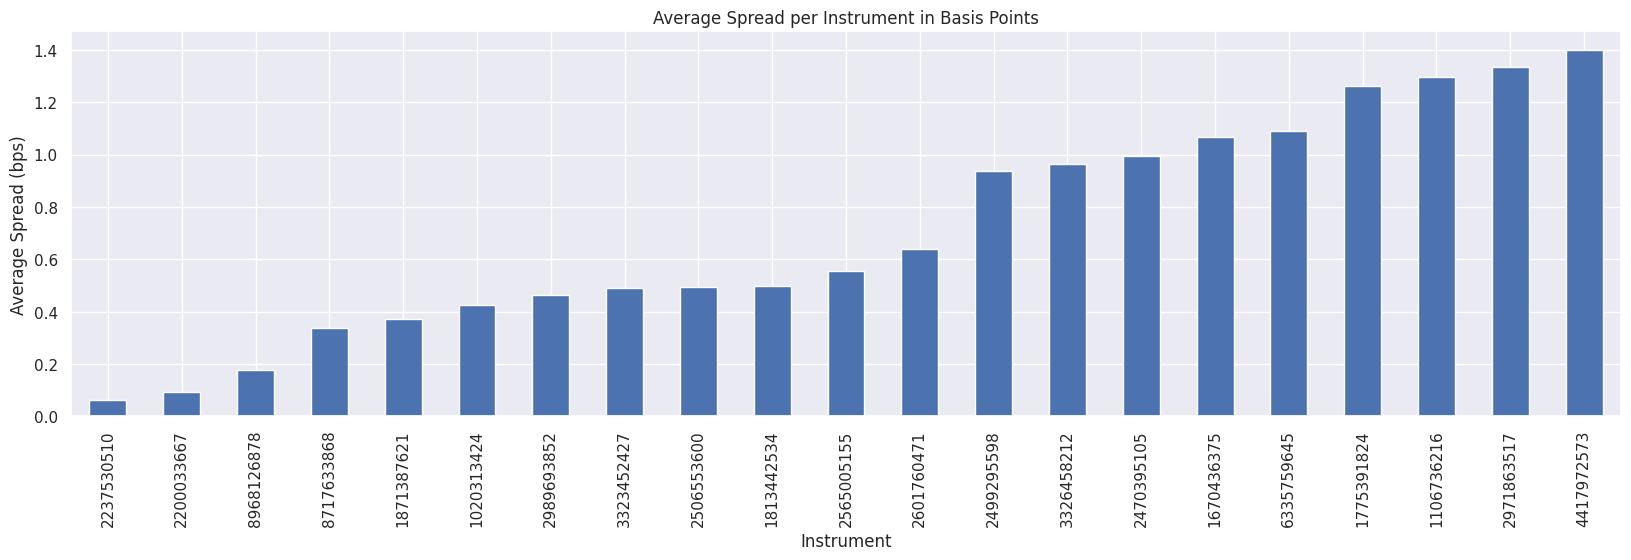

In [78]:
mean_spread_bps.sort_values().plot(
    kind="bar",
    title="Average Spread per Instrument in Basis Points",
    xlabel="Instrument",
    ylabel="Average Spread (bps)",
)

### OHLCV high-low range to tick ratio

<Axes: title={'center': 'Average high/low range to tick size per instrument (log)'}, xlabel='Instrument', ylabel='Average high/low range to tick size (log)'>

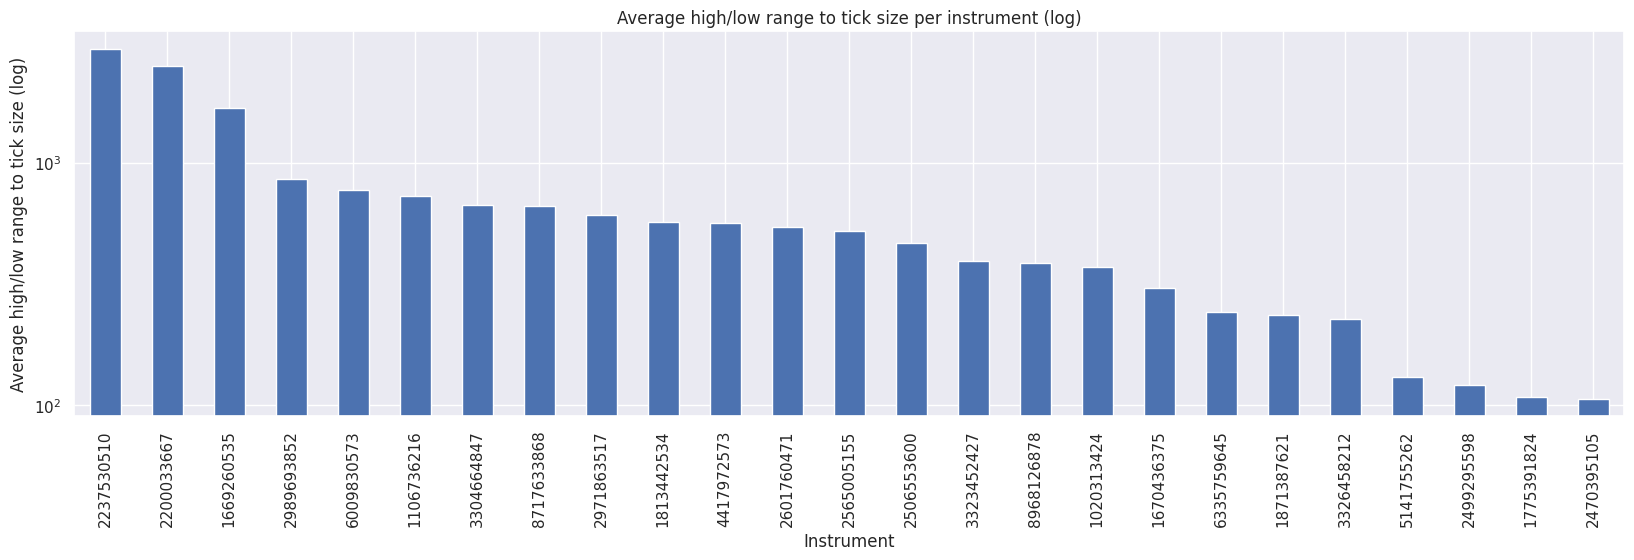

In [79]:
# Calculate the high-low range to tick ratio.
high_low_range = (ohlcv_bars["high"] - ohlcv_bars["low"]) / price_tick_srs
# Plot average.
high_low_range.mean().sort_values(ascending=False).plot(
    kind="bar",
    logy=True,
    title="Average high/low range to tick size per instrument (log)",
    xlabel="Instrument",
    ylabel="Average high/low range to tick size (log)",
)

## Volatility and top-of-book notional

### Volatility

In [80]:
# Brutally average volatility in bps by asset.
mean_vol_bps = child_order_df.groupby("asset_id")["total_vol_bps"].mean()

In [81]:
mean_vol_bps.sort_values(ascending=False)

asset_id
2971863517    6.594631
4417972573    6.213277
2601760471    5.816174
1106736216    5.180690
2200033667    4.459956
1775391824    3.959352
2989693852    3.902293
6335759645    3.694168
3326458212    3.427945
2237530510    3.401809
2506553600    3.348611
2470395105    3.122512
8717633868    2.955318
2565005155    2.913345
1813442534    2.658160
2499295598    2.606429
1020313424    2.465400
3323452427    2.162510
1871387621    1.803163
1670436375    1.241107
8968126878    0.854692
Name: total_vol_bps, dtype: float64

<Axes: >

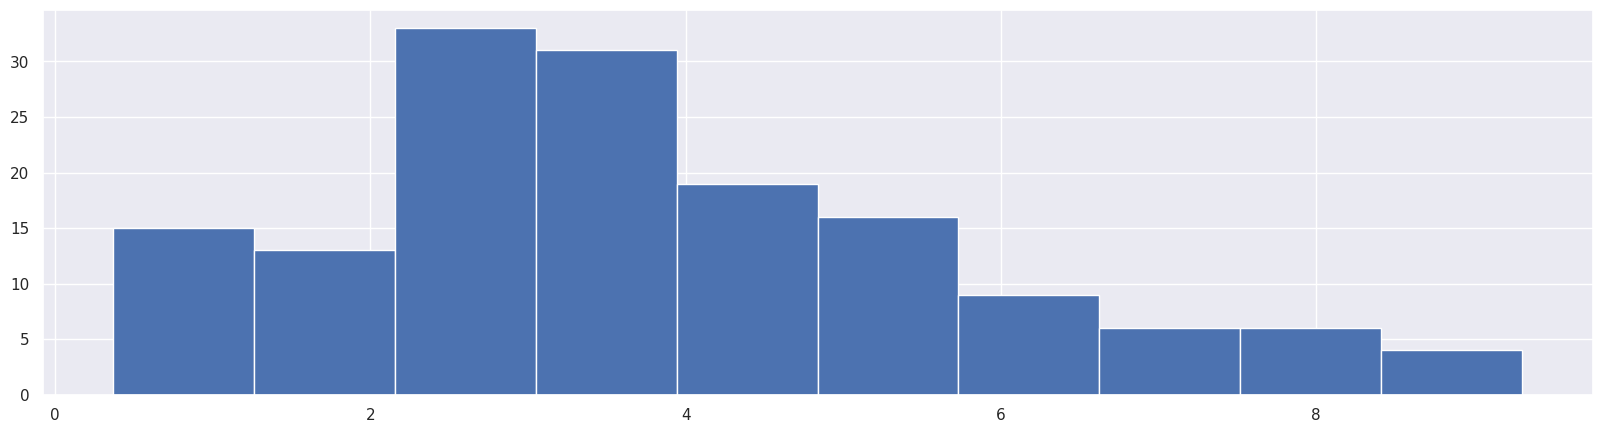

In [82]:
# Total volatility in bps histogram.
child_order_df["total_vol_bps"].hist()

### Bid/ask notional

In [83]:
# TODO: Factor out these calculations.

# Mean bid notional by asset id.
bid_notional = (
    child_order_df["latest_bid_price"] * child_order_df["latest_bid_size"]
).rename("bid_notional")
pd.concat([child_order_df["asset_id"], bid_notional], axis=1).groupby(
    "asset_id"
).mean().squeeze().sort_values(ascending=False)

asset_id
2237530510    13744.329909
8968126878     6497.104000
1871387621     3494.704260
2565005155     3435.573636
2601760471     3246.119064
3326458212     2670.582608
8717633868     1572.804333
6335759645     1144.157667
1020313424     1077.687787
2971863517      880.764094
4417972573      808.575927
2506553600      693.773283
1775391824      666.738000
3323452427      633.881255
2200033667      553.999987
1106736216      523.769760
2499295598      324.223490
1813442534      174.774485
1670436375      125.734067
2470395105      122.040917
2989693852       83.299367
Name: bid_notional, dtype: float64

In [84]:
# Mean ask notional by asset id.
ask_notional = (
    child_order_df["latest_ask_price"] * child_order_df["latest_ask_size"]
).rename("ask_notional")
pd.concat([child_order_df["asset_id"], ask_notional], axis=1).groupby(
    "asset_id"
).mean().squeeze().sort_values(ascending=False)

asset_id
8968126878    17538.555389
2237530510    10912.340273
2601760471     2563.671077
2470395105     2385.346543
3323452427     2290.331498
3326458212     1702.426694
1020313424     1691.791510
6335759645     1253.197833
8717633868      998.186833
2565005155      956.787327
2200033667      625.878913
1871387621      570.540680
1775391824      529.640150
2971863517      330.589475
1670436375      291.327467
2506553600      266.512783
1813442534      253.703250
4417972573      227.574293
1106736216      220.352060
2499295598       86.596457
2989693852       81.961233
Name: ask_notional, dtype: float64

In [85]:
# Use for round off.
round_to = 9

## Underfill share counts

In [86]:
# Calculate underfills from parent orders and fills.

# Extract the share amounts from the parent orders.
parent_order_amount = (
    parent_order_df.set_index(["end_timestamp", "asset_id"])
    .sort_index()["diff_num_shares"]
    .abs()
)
# Subtract the bar fill amounts from the parent order amounts.
underfill_shares = parent_order_amount.subtract(
    bar_fills["amount"], fill_value=0
).replace(-0.0, 0.0)
# Group by asset id.
underfill_shares.abs().groupby(level=1).sum().round(round_to)

asset_id
1020313424    0.0
1106736216    0.0
1670436375    0.0
1775391824    0.0
1813442534    0.0
1871387621    0.0
2200033667    0.0
2237530510    0.0
2470395105    0.0
2499295598    0.0
2506553600    0.0
2565005155    0.0
2601760471    0.0
2971863517    0.0
2989693852    0.0
3323452427    0.0
3326458212    0.0
4417972573    0.0
6335759645    0.0
8717633868    0.0
8968126878    0.0
dtype: float64

In [87]:
# Show underfills calculated from reconstructed portfolio.
execution_quality_df["underfill_share_count"].abs().sum().round(9)

1020313424    0.0
1106736216    0.0
1670436375    0.0
1775391824    0.0
1813442534    0.0
1871387621    0.0
2200033667    0.0
2237530510    0.0
2470395105    0.0
2499295598    0.0
2506553600    0.0
2565005155    0.0
2601760471    0.0
2971863517    0.0
2989693852    0.0
3323452427    0.0
3326458212    0.0
4417972573    0.0
6335759645    0.0
8717633868    0.0
8968126878    0.0
dtype: float64

## Underfill notional

In [88]:
# Get the total underfill notional for the run per asset.
execution_quality_df["underfill_notional"].abs().sum().round(round_to)

1020313424    0.0
1106736216    0.0
1670436375    0.0
1775391824    0.0
1813442534    0.0
1871387621    0.0
2200033667    0.0
2237530510    0.0
2470395105    0.0
2499295598    0.0
2506553600    0.0
2565005155    0.0
2601760471    0.0
2971863517    0.0
2989693852    0.0
3323452427    0.0
3326458212    0.0
4417972573    0.0
6335759645    0.0
8717633868    0.0
8968126878    0.0
dtype: float64

In [89]:
# Get the total underfill notional for the run per bar.
execution_quality_df["underfill_notional"].abs().sum(axis=1).round(round_to)

2024-05-16 22:00:00+00:00    0.0
2024-05-17 00:00:00+00:00    0.0
2024-05-17 02:00:00+00:00    0.0
2024-05-17 04:00:00+00:00    0.0
2024-05-17 06:00:00+00:00    0.0
2024-05-17 08:00:00+00:00    0.0
2024-05-17 10:00:00+00:00    0.0
Freq: 2H, dtype: float64

In [90]:
# Get the total underfill notional.
execution_quality_df["underfill_notional"].abs().sum().sum().round(round_to)

0.0

## Aggregate fill rate

In [91]:
underfill_notional = execution_quality_df["underfill_notional"].abs().sum()
executed_volume_notional = portfolio_df["executed_trades_notional"].abs().sum()
executed_volume_notional / (underfill_notional + executed_volume_notional)

asset_id
1020313424    1.0
1106736216    1.0
1670436375    1.0
1775391824    1.0
1813442534    1.0
1871387621    1.0
2200033667    1.0
2237530510    1.0
2470395105    1.0
2499295598    1.0
2506553600    1.0
2565005155    1.0
2601760471    1.0
2971863517    1.0
2989693852    1.0
3323452427    1.0
3326458212    1.0
4417972573    1.0
6335759645    1.0
8717633868    1.0
8968126878    1.0
dtype: float64

In [92]:
# Total portfolio aggregate fill rate.
total_underfill_notional = underfill_notional.sum()
total_executed_volume_notional = executed_volume_notional.sum()
total_executed_volume_notional / (
    total_underfill_notional + total_executed_volume_notional
)

1.0

## Notional slippage

In [93]:
# Per-share slippage.
actual_vs_ohlcv_execution_df = cofinanc.compute_ref_price_execution_quality(
    actual_and_ohlcv_price_df,
    "open",
    "open",
    "buy_trade_price",
    "sell_trade_price",
)
hpandas.df_to_str(
    actual_vs_ohlcv_execution_df, num_rows=6, log_level=logging.INFO
)

buy_trade_slippage_notional                                                                                                                                                                                                                                                                         buy_trade_slippage_bps                                                                                                                                                                                                                                                                         sell_trade_slippage_notional                                                                                                                                                                                                                                                                         sell_trade_slippage_bps                                                                                                                                                                                                                                                                        
                                           1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878             1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878                   1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878              1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878
2024-05-16 22:00:00+00:00                         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                          NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                     NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2024-05-17 00:00:00+00:00                         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN      -0.09        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     0.0014        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN  -5.662906        NaN        NaN        NaN       

In [94]:
buy_slippage_notional = (
    actual_vs_ohlcv_execution_df["buy_trade_slippage_notional"]
    * bar_fills["buy_volume"].unstack()
)
sell_slippage_notional = (
    actual_vs_ohlcv_execution_df["sell_trade_slippage_notional"]
    * bar_fills["sell_volume"].unstack()
)

In [95]:
# Compute total notional slippage in two ways.
slippage_notional_total_1 = (
    buy_slippage_notional.sum(axis=1) + sell_slippage_notional.sum(axis=1)
).sum()
slippage_notional_total_2 = execution_quality_df["slippage_notional"].sum().sum()

In [96]:
slippage_notional_by_asset_1 = (
    buy_slippage_notional.sum(axis=0) + sell_slippage_notional.sum(axis=0)
).rename("slippage_notional_1")
slippage_notional_by_timestamp_1 = (
    buy_slippage_notional.sum(axis=1) + sell_slippage_notional.sum(axis=1)
).rename("slippage_notional_1")

In [97]:
slippage_notional_by_asset_2 = (
    execution_quality_df["slippage_notional"].sum().rename("slippage_notional_2")
)
slippage_notional_by_timestamp_2 = (
    execution_quality_df["slippage_notional"]
    .sum(axis=1)
    .rename("slippage_notional_2")
)

In [98]:
pd.Series(
    {
        "slippage_notional_1": slippage_notional_total_1,
        "slippage_notional_2": slippage_notional_total_2,
    },
)

slippage_notional_1    1.66500
slippage_notional_2    1.89562
dtype: float64

In [99]:
pd.concat(
    [
        slippage_notional_by_asset_1,
        slippage_notional_by_asset_2,
    ],
    axis=1,
)

,slippage_notional_1,slippage_notional_2
1020313424,-0.05088,-0.04664
1106736216,0.00000,0.18000
1669260535,0.00000,NaN
1670436375,-0.00710,-0.01420
1775391824,0.05040,0.05040
1813442534,-0.12321,-0.09990
1871387621,0.07030,0.06290
2200033667,0.17420,0.17240
2237530510,-0.12700,-0.10000
2470395105,-0.02988,-0.03735


In [100]:
pd.concat(
    [
        slippage_notional_by_timestamp_1,
        slippage_notional_by_timestamp_2,
    ],
    axis=1,
)

,slippage_notional_1,slippage_notional_2
2024-05-16 22:00:00+00:00,0.00000,0.00000
2024-05-17 00:00:00+00:00,-0.23970,-0.25304
2024-05-17 02:00:00+00:00,0.86920,0.88049
2024-05-17 04:00:00+00:00,0.95118,0.93685
2024-05-17 06:00:00+00:00,0.38338,0.33132
2024-05-17 08:00:00+00:00,-0.29906,0.00000
2024-05-17 10:00:00+00:00,0.00000,0.00000


### Slippage in bps adjusted by total executed volume

In [101]:
# Total.
execution_quality_df[
    "slippage_notional"
].sum().sum() * 1e4 / executed_volume_notional.sum().round(round_to)

2.765183108921101

In [102]:
# By asset.
execution_quality_df[
    "slippage_notional"
].sum() * 1e4 / executed_volume_notional.round(round_to)

1020313424    -2.335159
1106736216     9.140025
1670436375    -0.710076
1775391824     2.525890
1813442534    -4.981320
1871387621     3.174188
2200033667     4.431198
2237530510    -1.556130
2470395105    -1.863099
2499295598    -0.937647
2506553600    -1.378371
2565005155     9.796127
2601760471     9.595144
2971863517    -2.501310
2989693852    -2.606977
3323452427     2.389398
3326458212     9.437870
4417972573    11.572884
6335759645    -5.311759
8717633868    -5.911429
8968126878    -0.175767
dtype: float64

In [103]:
# By timestamp.
execution_quality_df["slippage_notional"].sum(axis=1) * 1e4 / portfolio_df[
    "executed_trades_notional"
].abs().sum(axis=1).round(round_to)

2024-05-16 22:00:00+00:00         NaN
2024-05-17 00:00:00+00:00   -2.311030
2024-05-17 02:00:00+00:00    6.895233
2024-05-17 04:00:00+00:00    5.025138
2024-05-17 06:00:00+00:00    2.198443
2024-05-17 08:00:00+00:00    0.000000
2024-05-17 10:00:00+00:00         NaN
Freq: 2H, dtype: float64

## Compute vol-adjusted close price for unfilled orders

In [104]:
# Annotate child orders with parent order id.
child_order_df["parent_order_id"] = child_order_df.extra_params.apply(
    lambda x: x["oms_parent_order_id"]
)
child_order_df_by_parent = child_order_df.reset_index().set_index(
    ["parent_order_id", "order_id"]
)

In [105]:
zero_vol = child_order_df_by_parent[child_order_df_by_parent["total_vol"] == 0]
if not zero_vol.empty:
    _LOG.warning(
        "%d `total_vol` values will be replaces with NaN",
        len(zero_vol),
    )
    display(zero_vol)
    # Replace zeros with NaN to avoid division by zero.
    child_order_df_by_parent["total_vol"] = child_order_df_by_parent[
        "total_vol"
    ].replace(0, np.nan)

In [106]:
# Get `close` price as defined in `get_adjusted_close_price` docstring.
child_order_df_by_parent["close"] = child_order_df_by_parent.groupby(level=0)[
    "latest_mid_price"
].shift(-1)
# Calculate volatility-adjusted close price.
adjusted_close = list(
    map(
        obccexqu.get_adjusted_close_price,
        child_order_df_by_parent["close"],
        child_order_df_by_parent["latest_mid_price"],
        child_order_df_by_parent["total_vol"],
    )
)
child_order_df_by_parent["adj_close"] = adjusted_close

In [107]:
# Filter to only unfilled child orders.
unfilled_child_order_df = child_order_df_by_parent[
    child_order_df_by_parent["ccxt_id"].isin(unfilled_ccxt_orders.index)
]
unfilled_child_order_df.head(3)

creation_timestamp    asset_id  type_                  start_timestamp             end_timestamp  curr_num_shares  diff_num_shares                tz                                       extra_params  volatility_multiple  wave_id  num_data_points               exchange_timestamp              knowledge_timestamp           end_download_timestamp  latest_bid_size  latest_ask_size  num_data_points_resampled  scaling_multiplier   bid_vol  bid_vol_bps  latest_bid_price   ask_vol  ask_vol_bps  latest_ask_price  total_vol  latest_mid_price  total_vol_bps  spread  spread_bps  total_vol_to_spread_bps  limit_price      ccxt_id  name  attempt_num  lifespan_in_seconds    close  adj_close
parent_order_id order_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
127             140      2024-05-17 04:00:10.958357+00:00  1020313424  limit 2024-05-17 04:00:10.958357+00:00 2024-05-17 04:00:20+00:00             42.4            -42.4  America/New_York  {'stats': {'_submit_twap_child_order::wave_id'...                  1.5        0              303 2024-05-17 04:00:10.405000+00:00 2024-05-17 04:00:10.524502+00:00 2024-05-17 04:00:10.479442+00:00             18.6           1266.9                        598                10.0  0.000597     2.538197            2.3533  0.000595     2.526145            2.3534   0.000596           2.35335       2.532178  0.0001    0.424926                 5.959101       2.3542  10537584644   140            1                8.706  2.35325  -0.167811
71              86       2024-05-17 02:00:10.416283+00:00  1106736216  limit 2024-05-17 02:00:10.416283+00:00 2024-05-17 02:00:20+00:00              0.0            -40.0  America/New_York  {'stats': {'_submit_twap_child_order::wave_id'...                  0.7        1              269 2024-05-17 02:00:09.742000+00:00 2024-05-17 02:00:09.853697+00:00 2024-05-17 02:00:09.839865+00:00            199.0              5.0                        598                10.0  0.001081     4.374185            2.4702  0.001204     4.874743            2.4707   0.001144           2.47045       4.631282  0.0005    2.023923                 2.288270       2.4710   4214082116    86            1                9.230  2.46840  -1.791746
                100      2024-05-17 02:00:20.598018+00:00  1106736216  limit 2024-05-17 02:00:20.598018+00:00 2024-05-17 02:00:30+00:00              0.0            -40.0  America/New_York  {'stats': {'_submit_twap_child_order::wave_id'...                  0.7        2              295 2024-05-17 02:00:19.977000+00:00 2024-05-17 02:00:20.100050+00:00 2024-05-17 02:00:19.986865+00:00             84.0            138.0                        598                10.0  0.001227     4.971583            2.4683  0.001346     5.453726            2.4685   0.001288           2.46840       5.218246  0.0002    0.810241                 6.440359       2.4692   4214083987   100            1                9.103  2.46605  -1.824432

In [108]:
# Separate unfilled child orders by side.
unfilled_child_order_df_buy = unfilled_child_order_df[
    unfilled_child_order_df["diff_num_shares"] > 0
]
unfilled_child_order_df_sell = unfilled_child_order_df[
    unfilled_child_order_df["diff_num_shares"] < 0
]

In [109]:
# Display mean adjusted close by side.
_LOG.info(
    "Mean adjusted close for unfilled buy orders: %s",
    unfilled_child_order_df_buy["adj_close"].dropna().mean(),
)
_LOG.info(
    "Mean adjusted close for unfilled sell orders: %s",
    unfilled_child_order_df_sell["adj_close"].dropna().mean(),
)

INFO  Mean adjusted close for unfilled buy orders: 0.8486755853169035
INFO  Mean adjusted close for unfilled sell orders: -0.7222619094611751


In [110]:
# Display mean adjusted close by wave_id, buy orders.
unfilled_child_order_df_buy.groupby("wave_id")["adj_close"].mean().round(9)

wave_id
0    0.767690
1    1.367340
2    0.443265
3    0.207993
4    0.314491
Name: adj_close, dtype: float64

In [111]:
# Display mean adjusted close by wave_id, sell orders.
unfilled_child_order_df_sell.groupby("wave_id")["adj_close"].mean().round(9)

wave_id
0   -0.630957
1   -0.713607
2   -1.181015
3   -0.425735
4   -0.297223
5   -1.736598
Name: adj_close, dtype: float64

# Config after notebook run

In [112]:
print(config.to_string(mode="verbose"))

meta (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
  id_col (marked_as_used=True, writer=/tmp/ipykernel_7938/83629585.py::5::<module>, val_type=str): asset_id
  price_col (marked_as_used=True, writer=/tmp/ipykernel_7938/83629585.py::6::<module>, val_type=str): close
  use_historical (marked_as_used=False, writer=None, val_type=bool): True
system_log_dir (marked_as_used=True, writer=/tmp/ipykernel_7938/3320136017.py::2::<module>, val_type=str): /shared_data/ecs/preprod/system_reconciliation/C11a.config3/prod/20240516_220000.20240517_100000/system_log_dir.manual/process_forecasts
market_data (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
  vendor (marked_as_used=True, writer=/tmp/ipykernel_7938/1021137790.py::4::<module>, val_type=str): CCXT
  mode (marked_as_used=True, writer=/tmp/ipykernel_7938/1021137790.py::10::<module>, val_type=str): trade
  universe (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
 